# Part I: Set Up

- Import Packages

In [1]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt2
import pandas as pd
from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from keras.models import load_model
import keras
import h5py
import os
from statistics import mean
from keras import backend as K
from keras.layers.convolutional import Convolution1D, MaxPooling1D
from keras.layers.core import Flatten
from mosek.fusion import *

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


- Initialize Variables

In [2]:
seq_len

NameError: name 'seq_len' is not defined

In [2]:
seq_len = 22
shape = [seq_len, 9, 1]
neurons = [256, 256, 32, 1]
dropout = 0.3
decay = 0.5
epochs = 90
os.chdir("/Users/youssefberrada/Dropbox (MIT)/15.961 Independant Study/Data")
#os.chdir("/Users/michelcassard/Dropbox (MIT)/15.960 Independant Study/Data")
file = 'FX-5-merg.xlsx'
# Load spreadsheet
xl = pd.ExcelFile(file)

# Part 2: Data

- Load Data

In [3]:
def get_stock_data(stock_name, ma=[]):
    """
    Return a dataframe of that stock and normalize all the values. 
    (Optional: create moving average)
    
    """
    df = xl.parse(stock_name)
    df.set_index('Date', inplace=True)
    
    # Renaming all the columns so that we can use the old version code
    df.rename(columns={'OPEN': 'Open', 'HIGH': 'High', 'LOW': 'Low', 'NUMBER_TICKS': 'Volume', 'LAST_PRICE': 'Adj Close'}, inplace=True)
     # Percentage change
    df['Pct'] = df['Adj Close'].pct_change()
    df.dropna(inplace=True)
    
    # Moving Average    
    if ma != []:
        for moving in ma:
            df['{}ma'.format(moving)] = df['Adj Close'].rolling(window=moving).mean()
    df.dropna(inplace=True)
    
  
    # Move Adj Close to the rightmost for the ease of training
    adj_close = df['Adj Close']
    df.drop(labels=['Adj Close'], axis=1, inplace=True)
    df = pd.concat([df, adj_close], axis=1)
      
    return df

In [4]:
df_GBP=get_stock_data("GBP Curncy",  ma=[50, 100, 200])

- Visualize the data

In [5]:
def plot_stock(df):
    print(df.head())
    plt.subplot(211)
    plt.plot(df['Adj Close'], color='red', label='Adj Close')
    plt.legend(loc='best')
    plt.subplot(212)
    plt.plot(df['Pct'], color='blue', label='Percentage change')
    plt.legend(loc='best')
    plt.show()

                       Open    High     Low  Volume       Pct      50ma  \
Date                                                                      
2017-09-26 09:45:00  1.3444  1.3433  1.3442    4299 -0.000372  1.343802   
2017-09-26 09:50:00  1.3447  1.3437  1.3437    4947  0.000521  1.343738   
2017-09-26 09:55:00  1.3446  1.3431  1.3444    5552 -0.000818  1.343648   
2017-09-26 10:00:00  1.3438  1.3431  1.3433    7210  0.000074  1.343562   
2017-09-26 10:05:00  1.3443  1.3432  1.3434    5257  0.000447  1.343502   

                        100ma     200ma  Adj Close  
Date                                                
2017-09-26 09:45:00  1.346129  1.346931     1.3437  
2017-09-26 09:50:00  1.346099  1.346920     1.3444  
2017-09-26 09:55:00  1.346056  1.346904     1.3433  
2017-09-26 10:00:00  1.346018  1.346886     1.3434  
2017-09-26 10:05:00  1.345986  1.346872     1.3440  


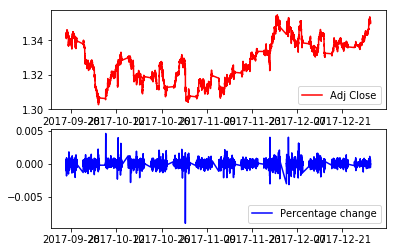

In [6]:
plot_stock(df_GBP)

- Training/Test Set

In [7]:
def load_data(stock,normalize,seq_len,split,ma):
    amount_of_features = len(stock.columns)
    print ("Amount of features = {}".format(amount_of_features))
    sequence_length = seq_len + 1 
    result_train = []
    result_test= []
    row = round(split * stock.shape[0]) 
    df_train=stock[0:row].copy()
    print ("Amount of training data = {}".format(df_train.shape[0]))
    df_test=stock[row:len(stock)].copy()
    print ("Amount of testing data = {}".format(df_test.shape[0]))

    
    if normalize:
        #Training
        min_max_scaler = preprocessing.MinMaxScaler()
        df_train['Open'] = min_max_scaler.fit_transform(df_train.Open.values.reshape(-1,1))
        df_train['High'] = min_max_scaler.fit_transform(df_train.High.values.reshape(-1,1))
        df_train['Low'] = min_max_scaler.fit_transform(df_train.Low.values.reshape(-1,1))
        df_train['Volume'] = min_max_scaler.fit_transform(df_train.Volume.values.reshape(-1,1))
        df_train['Adj Close'] = min_max_scaler.fit_transform(df_train['Adj Close'].values.reshape(-1,1))
        df_train['Pct'] = min_max_scaler.fit_transform(df_train['Pct'].values.reshape(-1,1))
        if ma != []:
            for moving in ma:
                df_train['{}ma'.format(moving)] = min_max_scaler.fit_transform(df_train['{}ma'.format(moving)].values.reshape(-1,1))  
        #Test
        df_test['Open'] = min_max_scaler.fit_transform(df_test.Open.values.reshape(-1,1))
        df_test['High'] = min_max_scaler.fit_transform(df_test.High.values.reshape(-1,1))
        df_test['Low'] = min_max_scaler.fit_transform(df_test.Low.values.reshape(-1,1))
        df_test['Volume'] = min_max_scaler.fit_transform(df_test.Volume.values.reshape(-1,1))
        df_test['Adj Close'] = min_max_scaler.fit_transform(df_test['Adj Close'].values.reshape(-1,1))
        df_test['Pct'] = min_max_scaler.fit_transform(df_test['Pct'].values.reshape(-1,1))
        if ma != []:
            for moving in ma:
                df_test['{}ma'.format(moving)] = min_max_scaler.fit_transform(df_test['{}ma'.format(moving)].values.reshape(-1,1))  
     
    #Training
    data_train = df_train.as_matrix()
    for index in range(len(data_train) - sequence_length): 
        result_train.append(data_train[index: index + sequence_length]) 
    train = np.array(result_train)
    X_train = train[:, :-1].copy() # all data until day m
    y_train = train[:, -1][:,-1].copy() # day m + 1 adjusted close price

    #Test
    data_test = df_test.as_matrix()
    for index in range(len(data_test) - sequence_length): 
        result_test.append(data_test[index: index + sequence_length]) 
    test = np.array(result_train)
    X_test = test[:, :-1].copy()
    y_test = test[:, -1][:,-1].copy()

    
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], amount_of_features))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], amount_of_features))

    return [X_train, y_train, X_test, y_test]

In [8]:
X_train, y_train, X_test, y_test = load_data(df_GBP,True,seq_len,split=0.7,ma=[50, 100, 200])

Amount of features = 9
Amount of training data = 13724
Amount of testing data = 5882


/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


# 3. Model

In [9]:
def build_model(shape, neurons, dropout, decay):
    model = Sequential()

    #model.add(Dense(neurons[0],activation="relu", input_shape=(shape[0], shape[1])))
    
    model.add(LSTM(neurons[0], input_shape=(shape[0], shape[1]), return_sequences=True))
    model.add(Dropout(dropout))

    model.add(LSTM(neurons[1], input_shape=(shape[0], shape[1]), return_sequences=False))
    model.add(Dropout(dropout))

    model.add(Dense(neurons[2],kernel_initializer="uniform",activation='relu'))
    model.add(Dense(neurons[3],kernel_initializer="uniform",activation='linear'))
    
    adam = keras.optimizers.Adam(decay=decay)
    model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

In [10]:
def build_model_CNN(shape, neurons, dropout, decay):
    model = Sequential()
    model.add(Convolution1D(input_shape = (shape[0], shape[1]), 
                        nb_filter=64,
                        filter_length=2,
                        border_mode='valid',
                        activation='relu',
                        subsample_length=1))
    model.add(MaxPooling1D(pool_length=2))

    model.add(Convolution1D(input_shape = (shape[0], shape[1]), 
                        nb_filter=64,
                        filter_length=2,
                        border_mode='valid',
                        activation='relu',
                        subsample_length=1))
    model.add(MaxPooling1D(pool_length=2))

    model.add(Dropout(0.25))
    model.add(Flatten())

    model.add(Dense(250))
    model.add(Dropout(0.25))
    model.add(Activation('relu'))

    model.add(Dense(1))
    model.add(Activation('linear'))
    adam = keras.optimizers.Adam(decay=decay)
    model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

In [11]:
model = build_model_CNN(shape, neurons, dropout, decay)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(input_shape=(22, 9), activation="relu", filters=64, kernel_size=2, strides=1, padding="valid")`
  


Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 21, 64)            1216      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 10, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 9, 64)             8256      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 4, 64)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 4, 64)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 256)               0         
___________________________________________________________

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `MaxPooling1D` call to the Keras 2 API: `MaxPooling1D(pool_size=2)`
  if __name__ == '__main__':
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(input_shape=(22, 9), activation="relu", filters=64, kernel_size=2, strides=1, padding="valid")`
  app.launch_new_instance()
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Update your `MaxPooling1D` call to the Keras 2 API: `MaxPooling1D(pool_size=2)`


# 4. Results

- Model Fit

In [56]:
model.fit(X_train,y_train,batch_size=512,epochs=epochs,validation_split=0.3,verbose=1)

Train on 9782 samples, validate on 4193 samples
Epoch 1/90
9782/9782 [==============================] - 2s 157us/step - loss: 0.0300 - acc: 1.0223e-04 - val_loss: 0.0027 - val_acc: 2.3849e-04
Epoch 2/90
9782/9782 [==============================] - 0s 45us/step - loss: 0.0062 - acc: 1.0223e-04 - val_loss: 8.3929e-04 - val_acc: 2.3849e-04
Epoch 3/90
9782/9782 [==============================] - 0s 46us/step - loss: 0.0040 - acc: 1.0223e-04 - val_loss: 0.0019 - val_acc: 2.3849e-04
Epoch 4/90
9782/9782 [==============================] - 1s 53us/step - loss: 0.0031 - acc: 1.0223e-04 - val_loss: 0.0017 - val_acc: 2.3849e-04
Epoch 5/90
9782/9782 [==============================] - 0s 44us/step - loss: 0.0025 - acc: 1.0223e-04 - val_loss: 0.0021 - val_acc: 2.3849e-04
Epoch 6/90
9782/9782 [==============================] - 1s 53us/step - loss: 0.0023 - acc: 1.0223e-04 - val_loss: 0.0019 - val_acc: 2.3849e-04
Epoch 7/90
9782/9782 [==============================] - 1s 57us/step - loss: 0.0019 - acc

- Model Score

In [12]:
def model_score(model, X_train, y_train, X_test, y_test):
    trainScore = model.evaluate(X_train, y_train, verbose=0)
    print('Train Score: %.5f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

    testScore = model.evaluate(X_test, y_test, verbose=0)
    print('Test Score: %.5f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))
    return trainScore[0], testScore[0]

In [58]:
model_score(model, X_train, y_train, X_test, y_test)

Train Score: 0.00037 MSE (0.02 RMSE)
Test Score: 0.00037 MSE (0.02 RMSE)


(0.0003710565636182714, 0.0003710565636182714)

In [13]:
def percentage_difference(model, X_test, y_test):
    percentage_diff=[]

    p = model.predict(X_test)
    for u in range(len(y_test)): # for each data index in test data
        pr = p[u][0] # pr = prediction on day u

        percentage_diff.append((pr-y_test[u]/pr)*100)
    print(mean(percentage_diff))
    return p

In [232]:
p = percentage_difference(model, X_test, y_test)

523.7988228254899


In [14]:
def plot_result_norm(stock_name, normalized_value_p, normalized_value_y_test):
    newp=normalized_value_p
    newy_test=normalized_value_y_test
    plt2.plot(newp, color='red', label='Prediction')
    plt2.plot(newy_test,color='blue', label='Actual')
    plt2.legend(loc='best')
    plt2.title('The test result for {}'.format(stock_name))
    plt2.xlabel('5 Min ahead Forecast')
    plt2.ylabel('Price')
    plt2.show()

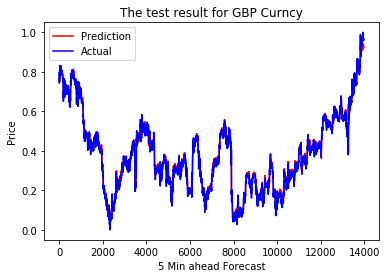

In [62]:
plot_result_norm("GBP Curncy", p, y_test)

In [15]:
def denormalize(stock_name, normalized_value,split=0.7,predict=True):
    """
    Return a dataframe of that stock and normalize all the values. 
    (Optional: create moving average)
    """
    df = xl.parse(stock_name)
    df.set_index('Date', inplace=True)
    
    # Renaming all the columns so that we can use the old version code
    df.rename(columns={'OPEN': 'Open', 'HIGH': 'High', 'LOW': 'Low', 'NUMBER_TICKS': 'Volume', 'LAST_PRICE': 'Adj Close'}, inplace=True)


    df.dropna(inplace=True)
    df = df['Adj Close'].values.reshape(-1,1)
    normalized_value = normalized_value.reshape(-1,1)
    
    row = round(split * df.shape[0]) 
    if predict:
        df_p=df[0:row].copy()
    else:
        df_p=df[row:len(df)].copy()
    
    #return df.shape, p.shape
    mean_df=np.mean(df_p)
    std_df=np.std(df_p)
    new=normalized_value*mean_df+std_df
      
    return new

In [16]:
def portfolio(currency_list,file = 'FX-5.xlsx',seq_len = 22,shape = [seq_len, 9, 1],neurons = [256, 256, 32, 1],dropout = 0.3,decay = 0.5,
              epochs = 90,ma=[50, 100, 200],split=0.7):
    i=0
    mini=99999999
    for currency in currency_list:
        df=get_stock_data(currency,  ma)
        X_train, y_train, X_test, y_test = load_data(df,True,seq_len,split,ma)
        model = build_model_CNN(shape, neurons, dropout, decay)
        model.fit(X_train,y_train,batch_size=512,epochs=epochs,validation_split=0.3,verbose=1)
        p = percentage_difference(model, X_test, y_test)
        newp = denormalize(currency, p,predict=True)
        if mini>p.size:
            mini=p.size
        if i==0:
            predict=p.copy()
        else:
            predict=np.hstack((predict[0:mini],p[0:mini]))
        i+=1
    return predict


In [92]:
currency_list=[ 'GBP Curncy',
 'JPY Curncy',
 'EUR Curncy',
 'CAD Curncy',
 'NZD Curncy',
 'SEK Curncy',
 'AUD Curncy',
 'CHF Curncy',
 'NOK Curncy',
 'ZAR Curncy']
#currency_list=['JPY Curncy']
predictcur=portfolio(currency_list,file = 'FX-5-merg.xlsx',seq_len = 22,shape = [seq_len, 9, 1],neurons = [256, 256, 32, 1],dropout = 0.3,decay = 0.5,
              epochs = 90,ma=[50, 100, 200],split=0.7)

Amount of features = 9
Amount of training data = 13724
Amount of testing data = 5882


/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(input_shape=(22, 9), activation="relu", filters=64, kernel_size=2, strides=1, padding="valid")`
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `MaxPooling1D` call to the Keras 2 API: `MaxPooling1D(pool_size=2)`
  if __name__ == '__main__':
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(input_shape=(22, 9), activation="relu", filters=64, kernel_size=2, strides=1, padding="valid")`
  app.launch_new_instance()
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Update your `MaxPooling1D` call to the Ke

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_21 (Conv1D)           (None, 21, 64)            1216      
_________________________________________________________________
max_pooling1d_21 (MaxPooling (None, 10, 64)            0         
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 9, 64)             8256      
_________________________________________________________________
max_pooling1d_22 (MaxPooling (None, 4, 64)             0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 4, 64)             0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 256)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 250)               64250     
__________

Epoch 45/90
9590/9590 [==============================] - 0s 43us/step - loss: 9.9877e-04 - acc: 1.0428e-04 - val_loss: 0.0017 - val_acc: 2.4325e-04
Epoch 46/90
9590/9590 [==============================] - 0s 43us/step - loss: 0.0010 - acc: 1.0428e-04 - val_loss: 8.9207e-04 - val_acc: 2.4325e-04
Epoch 47/90
9590/9590 [==============================] - 0s 42us/step - loss: 9.4027e-04 - acc: 1.0428e-04 - val_loss: 0.0012 - val_acc: 2.4325e-04
Epoch 48/90
9590/9590 [==============================] - 0s 43us/step - loss: 9.1174e-04 - acc: 1.0428e-04 - val_loss: 0.0014 - val_acc: 2.4325e-04
Epoch 49/90
9590/9590 [==============================] - 0s 43us/step - loss: 9.2689e-04 - acc: 1.0428e-04 - val_loss: 0.0011 - val_acc: 2.4325e-04
Epoch 50/90
9590/9590 [==============================] - 0s 45us/step - loss: 9.3503e-04 - acc: 1.0428e-04 - val_loss: 0.0012 - val_acc: 2.4325e-04
Epoch 51/90
9590/9590 [==============================] - 0s 46us/step - loss: 9.2716e-04 - acc: 1.0428e-04 - val

Train on 9590 samples, validate on 4111 samples
Epoch 1/90
9590/9590 [==============================] - 1s 132us/step - loss: 0.0789 - acc: 1.0428e-04 - val_loss: 0.0053 - val_acc: 2.4325e-04
Epoch 2/90
9590/9590 [==============================] - 0s 43us/step - loss: 0.0115 - acc: 1.0428e-04 - val_loss: 0.0025 - val_acc: 2.4325e-04
Epoch 3/90
9590/9590 [==============================] - 0s 44us/step - loss: 0.0074 - acc: 1.0428e-04 - val_loss: 0.0019 - val_acc: 2.4325e-04
Epoch 4/90
9590/9590 [==============================] - 0s 43us/step - loss: 0.0060 - acc: 1.0428e-04 - val_loss: 0.0016 - val_acc: 2.4325e-04
Epoch 5/90
9590/9590 [==============================] - 0s 43us/step - loss: 0.0054 - acc: 1.0428e-04 - val_loss: 0.0017 - val_acc: 2.4325e-04
Epoch 6/90
9590/9590 [==============================] - 0s 47us/step - loss: 0.0047 - acc: 1.0428e-04 - val_loss: 0.0026 - val_acc: 2.4325e-04
Epoch 7/90
9590/9590 [==============================] - 0s 43us/step - loss: 0.0041 - acc: 1.

9590/9590 [==============================] - 1s 64us/step - loss: 0.0016 - acc: 1.0428e-04 - val_loss: 0.0046 - val_acc: 2.4325e-04
Epoch 58/90
9590/9590 [==============================] - 1s 80us/step - loss: 0.0016 - acc: 1.0428e-04 - val_loss: 0.0047 - val_acc: 2.4325e-04
Epoch 59/90
9590/9590 [==============================] - 1s 71us/step - loss: 0.0015 - acc: 1.0428e-04 - val_loss: 0.0049 - val_acc: 2.4325e-04
Epoch 60/90
9590/9590 [==============================] - 1s 76us/step - loss: 0.0015 - acc: 1.0428e-04 - val_loss: 0.0059 - val_acc: 2.4325e-04
Epoch 61/90
9590/9590 [==============================] - 1s 77us/step - loss: 0.0015 - acc: 1.0428e-04 - val_loss: 0.0058 - val_acc: 2.4325e-04
Epoch 62/90
9590/9590 [==============================] - 1s 66us/step - loss: 0.0016 - acc: 1.0428e-04 - val_loss: 0.0058 - val_acc: 2.4325e-04
Epoch 63/90
9590/9590 [==============================] - 0s 50us/step - loss: 0.0016 - acc: 1.0428e-04 - val_loss: 0.0059 - val_acc: 2.4325e-04
Epoc

9590/9590 [==============================] - 0s 48us/step - loss: 0.0018 - acc: 1.0428e-04 - val_loss: 0.0011 - val_acc: 2.4325e-04
Epoch 11/90
9590/9590 [==============================] - 0s 46us/step - loss: 0.0018 - acc: 1.0428e-04 - val_loss: 0.0015 - val_acc: 2.4325e-04
Epoch 12/90
9590/9590 [==============================] - 0s 44us/step - loss: 0.0017 - acc: 1.0428e-04 - val_loss: 7.1723e-04 - val_acc: 2.4325e-04
Epoch 13/90
9590/9590 [==============================] - 0s 45us/step - loss: 0.0016 - acc: 1.0428e-04 - val_loss: 0.0012 - val_acc: 2.4325e-04
Epoch 14/90
9590/9590 [==============================] - 0s 43us/step - loss: 0.0016 - acc: 1.0428e-04 - val_loss: 0.0012 - val_acc: 2.4325e-04
Epoch 15/90
9590/9590 [==============================] - 0s 46us/step - loss: 0.0015 - acc: 1.0428e-04 - val_loss: 0.0015 - val_acc: 2.4325e-04
Epoch 16/90
9590/9590 [==============================] - 0s 43us/step - loss: 0.0015 - acc: 1.0428e-04 - val_loss: 8.9828e-04 - val_acc: 2.4325e

9590/9590 [==============================] - 0s 44us/step - loss: 9.2278e-04 - acc: 1.0428e-04 - val_loss: 6.5404e-04 - val_acc: 2.4325e-04
Epoch 66/90
9590/9590 [==============================] - 0s 44us/step - loss: 8.5759e-04 - acc: 1.0428e-04 - val_loss: 5.8734e-04 - val_acc: 2.4325e-04
Epoch 67/90
9590/9590 [==============================] - 0s 45us/step - loss: 8.3348e-04 - acc: 1.0428e-04 - val_loss: 6.1765e-04 - val_acc: 2.4325e-04
Epoch 68/90
9590/9590 [==============================] - 0s 46us/step - loss: 8.4673e-04 - acc: 1.0428e-04 - val_loss: 8.8950e-04 - val_acc: 2.4325e-04
Epoch 69/90
9590/9590 [==============================] - 0s 44us/step - loss: 8.3044e-04 - acc: 1.0428e-04 - val_loss: 6.6964e-04 - val_acc: 2.4325e-04
Epoch 70/90
9590/9590 [==============================] - 0s 44us/step - loss: 8.3440e-04 - acc: 1.0428e-04 - val_loss: 5.3265e-04 - val_acc: 2.4325e-04
Epoch 71/90
9590/9590 [==============================] - 0s 46us/step - loss: 8.8079e-04 - acc: 1.04

9590/9590 [==============================] - 0s 49us/step - loss: 0.0020 - acc: 2.0855e-04 - val_loss: 0.0026 - val_acc: 0.0000e+00
Epoch 18/90
9590/9590 [==============================] - 0s 52us/step - loss: 0.0019 - acc: 2.0855e-04 - val_loss: 0.0023 - val_acc: 0.0000e+00
Epoch 19/90
9590/9590 [==============================] - 0s 49us/step - loss: 0.0019 - acc: 2.0855e-04 - val_loss: 0.0041 - val_acc: 0.0000e+00
Epoch 20/90
9590/9590 [==============================] - 0s 50us/step - loss: 0.0019 - acc: 2.0855e-04 - val_loss: 0.0027 - val_acc: 0.0000e+00
Epoch 21/90
9590/9590 [==============================] - 0s 47us/step - loss: 0.0018 - acc: 2.0855e-04 - val_loss: 0.0026 - val_acc: 0.0000e+00
Epoch 22/90
9590/9590 [==============================] - 0s 52us/step - loss: 0.0019 - acc: 2.0855e-04 - val_loss: 0.0041 - val_acc: 0.0000e+00
Epoch 23/90
9590/9590 [==============================] - 0s 46us/step - loss: 0.0018 - acc: 2.0855e-04 - val_loss: 0.0030 - val_acc: 0.0000e+00
Epoc

9590/9590 [==============================] - 0s 45us/step - loss: 0.0013 - acc: 2.0855e-04 - val_loss: 0.0012 - val_acc: 0.0000e+00
Epoch 74/90
9590/9590 [==============================] - 0s 43us/step - loss: 0.0012 - acc: 2.0855e-04 - val_loss: 0.0012 - val_acc: 0.0000e+00
Epoch 75/90
9590/9590 [==============================] - 0s 43us/step - loss: 0.0012 - acc: 2.0855e-04 - val_loss: 9.8701e-04 - val_acc: 0.0000e+00
Epoch 76/90
9590/9590 [==============================] - 0s 44us/step - loss: 0.0012 - acc: 2.0855e-04 - val_loss: 0.0011 - val_acc: 0.0000e+00
Epoch 77/90
9590/9590 [==============================] - 0s 44us/step - loss: 0.0012 - acc: 2.0855e-04 - val_loss: 7.2231e-04 - val_acc: 0.0000e+00
Epoch 78/90
9590/9590 [==============================] - 0s 45us/step - loss: 0.0012 - acc: 2.0855e-04 - val_loss: 5.7937e-04 - val_acc: 0.0000e+00
Epoch 79/90
9590/9590 [==============================] - 0s 43us/step - loss: 0.0012 - acc: 2.0855e-04 - val_loss: 5.3919e-04 - val_acc:

Epoch 26/90
9590/9590 [==============================] - 0s 44us/step - loss: 0.0019 - acc: 2.0855e-04 - val_loss: 0.0011 - val_acc: 7.2975e-04
Epoch 27/90
9590/9590 [==============================] - 0s 42us/step - loss: 0.0021 - acc: 2.0855e-04 - val_loss: 0.0013 - val_acc: 7.2975e-04
Epoch 28/90
9590/9590 [==============================] - 0s 44us/step - loss: 0.0019 - acc: 2.0855e-04 - val_loss: 0.0013 - val_acc: 7.2975e-04
Epoch 29/90
9590/9590 [==============================] - 0s 43us/step - loss: 0.0019 - acc: 2.0855e-04 - val_loss: 0.0011 - val_acc: 7.2975e-04
Epoch 30/90
9590/9590 [==============================] - 0s 44us/step - loss: 0.0019 - acc: 2.0855e-04 - val_loss: 0.0011 - val_acc: 7.2975e-04
Epoch 31/90
9590/9590 [==============================] - 0s 43us/step - loss: 0.0019 - acc: 2.0855e-04 - val_loss: 0.0013 - val_acc: 7.2975e-04
Epoch 32/90
9590/9590 [==============================] - 0s 45us/step - loss: 0.0018 - acc: 2.0855e-04 - val_loss: 0.0013 - val_acc: 7.2

Epoch 83/90
9590/9590 [==============================] - 0s 45us/step - loss: 0.0012 - acc: 2.0855e-04 - val_loss: 0.0030 - val_acc: 7.2975e-04
Epoch 84/90
9590/9590 [==============================] - 0s 44us/step - loss: 0.0012 - acc: 2.0855e-04 - val_loss: 0.0029 - val_acc: 7.2975e-04
Epoch 85/90
9590/9590 [==============================] - 0s 44us/step - loss: 0.0013 - acc: 2.0855e-04 - val_loss: 0.0026 - val_acc: 7.2975e-04
Epoch 86/90
9590/9590 [==============================] - 0s 44us/step - loss: 0.0012 - acc: 2.0855e-04 - val_loss: 0.0029 - val_acc: 7.2975e-04
Epoch 87/90
9590/9590 [==============================] - 0s 44us/step - loss: 0.0011 - acc: 2.0855e-04 - val_loss: 0.0030 - val_acc: 7.2975e-04
Epoch 88/90
9590/9590 [==============================] - 0s 44us/step - loss: 0.0012 - acc: 2.0855e-04 - val_loss: 0.0031 - val_acc: 7.2975e-04
Epoch 89/90
9590/9590 [==============================] - 0s 44us/step - loss: 0.0013 - acc: 2.0855e-04 - val_loss: 0.0031 - val_acc: 7.2

Epoch 36/90
9590/9590 [==============================] - 0s 45us/step - loss: 0.0010 - acc: 1.0428e-04 - val_loss: 6.7997e-04 - val_acc: 2.4325e-04
Epoch 37/90
9590/9590 [==============================] - 0s 48us/step - loss: 0.0010 - acc: 1.0428e-04 - val_loss: 8.9316e-04 - val_acc: 2.4325e-04
Epoch 38/90
9590/9590 [==============================] - 0s 45us/step - loss: 9.9894e-04 - acc: 1.0428e-04 - val_loss: 5.7605e-04 - val_acc: 2.4325e-04
Epoch 39/90
9590/9590 [==============================] - 1s 61us/step - loss: 0.0010 - acc: 1.0428e-04 - val_loss: 5.5739e-04 - val_acc: 2.4325e-04
Epoch 40/90
9590/9590 [==============================] - 0s 51us/step - loss: 9.6445e-04 - acc: 1.0428e-04 - val_loss: 4.3384e-04 - val_acc: 2.4325e-04
Epoch 41/90
9590/9590 [==============================] - 0s 44us/step - loss: 9.9067e-04 - acc: 1.0428e-04 - val_loss: 5.0265e-04 - val_acc: 2.4325e-04
Epoch 42/90
9590/9590 [==============================] - 0s 46us/step - loss: 9.6450e-04 - acc: 1.04

9590/9590 [==============================] - 0s 48us/step - loss: 7.0774e-04 - acc: 1.0428e-04 - val_loss: 6.1670e-04 - val_acc: 2.4325e-04
-49.459388379281506
Amount of features = 9
Amount of training data = 13724
Amount of testing data = 5882
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_33 (Conv1D)           (None, 21, 64)            1216      
_________________________________________________________________
max_pooling1d_33 (MaxPooling (None, 10, 64)            0         
_________________________________________________________________
conv1d_34 (Conv1D)           (None, 9, 64)             8256      
_________________________________________________________________
max_pooling1d_34 (MaxPooling (None, 4, 64)             0         
_________________________________________________________________
dropout_33 (Dropout)         (None, 4, 64)             0         
_____________________________

9590/9590 [==============================] - 1s 55us/step - loss: 0.0019 - acc: 1.0428e-04 - val_loss: 0.0247 - val_acc: 4.8650e-04
Epoch 44/90
9590/9590 [==============================] - 1s 58us/step - loss: 0.0018 - acc: 1.0428e-04 - val_loss: 0.0279 - val_acc: 4.8650e-04
Epoch 45/90
9590/9590 [==============================] - 1s 54us/step - loss: 0.0017 - acc: 1.0428e-04 - val_loss: 0.0249 - val_acc: 4.8650e-04
Epoch 46/90
9590/9590 [==============================] - 1s 61us/step - loss: 0.0018 - acc: 1.0428e-04 - val_loss: 0.0254 - val_acc: 4.8650e-04
Epoch 47/90
9590/9590 [==============================] - 1s 54us/step - loss: 0.0018 - acc: 1.0428e-04 - val_loss: 0.0235 - val_acc: 4.8650e-04
Epoch 48/90
9590/9590 [==============================] - 0s 46us/step - loss: 0.0018 - acc: 1.0428e-04 - val_loss: 0.0248 - val_acc: 4.8650e-04
Epoch 49/90
9590/9590 [==============================] - 0s 46us/step - loss: 0.0018 - acc: 1.0428e-04 - val_loss: 0.0241 - val_acc: 4.8650e-04
Epoc

Train on 9590 samples, validate on 4111 samples
Epoch 1/90
9590/9590 [==============================] - 2s 173us/step - loss: 0.0441 - acc: 3.1283e-04 - val_loss: 0.0095 - val_acc: 0.0000e+00
Epoch 2/90
9590/9590 [==============================] - 0s 47us/step - loss: 0.0097 - acc: 4.1710e-04 - val_loss: 0.0015 - val_acc: 0.0000e+00
Epoch 3/90
9590/9590 [==============================] - 0s 49us/step - loss: 0.0063 - acc: 4.1710e-04 - val_loss: 0.0011 - val_acc: 0.0000e+00
Epoch 4/90
9590/9590 [==============================] - 0s 47us/step - loss: 0.0047 - acc: 4.1710e-04 - val_loss: 0.0013 - val_acc: 0.0000e+00
Epoch 5/90
9590/9590 [==============================] - 0s 47us/step - loss: 0.0040 - acc: 4.1710e-04 - val_loss: 8.7751e-04 - val_acc: 0.0000e+00
Epoch 6/90
9590/9590 [==============================] - 0s 47us/step - loss: 0.0036 - acc: 4.1710e-04 - val_loss: 0.0018 - val_acc: 0.0000e+00
Epoch 7/90
9590/9590 [==============================] - 0s 45us/step - loss: 0.0033 - acc

Epoch 57/90
9590/9590 [==============================] - 0s 47us/step - loss: 0.0014 - acc: 4.1710e-04 - val_loss: 4.4054e-04 - val_acc: 0.0000e+00
Epoch 58/90
9590/9590 [==============================] - 0s 47us/step - loss: 0.0014 - acc: 4.1710e-04 - val_loss: 4.6934e-04 - val_acc: 0.0000e+00
Epoch 59/90
9590/9590 [==============================] - 0s 46us/step - loss: 0.0014 - acc: 4.1710e-04 - val_loss: 5.5795e-04 - val_acc: 0.0000e+00
Epoch 60/90
9590/9590 [==============================] - 0s 46us/step - loss: 0.0014 - acc: 4.1710e-04 - val_loss: 4.2118e-04 - val_acc: 0.0000e+00
Epoch 61/90
9590/9590 [==============================] - 0s 45us/step - loss: 0.0014 - acc: 4.1710e-04 - val_loss: 9.2294e-04 - val_acc: 0.0000e+00
Epoch 62/90
9590/9590 [==============================] - 0s 46us/step - loss: 0.0016 - acc: 4.1710e-04 - val_loss: 6.6967e-04 - val_acc: 0.0000e+00
Epoch 63/90
9590/9590 [==============================] - 0s 47us/step - loss: 0.0015 - acc: 4.1710e-04 - val_los

9590/9590 [==============================] - 0s 47us/step - loss: 0.0015 - acc: 1.0428e-04 - val_loss: 0.0022 - val_acc: 2.4325e-04
Epoch 10/90
9590/9590 [==============================] - 0s 46us/step - loss: 0.0014 - acc: 1.0428e-04 - val_loss: 0.0026 - val_acc: 2.4325e-04
Epoch 11/90
9590/9590 [==============================] - 0s 46us/step - loss: 0.0013 - acc: 1.0428e-04 - val_loss: 0.0022 - val_acc: 2.4325e-04
Epoch 12/90
9590/9590 [==============================] - 0s 44us/step - loss: 0.0012 - acc: 1.0428e-04 - val_loss: 0.0028 - val_acc: 2.4325e-04
Epoch 13/90
9590/9590 [==============================] - 0s 46us/step - loss: 0.0012 - acc: 1.0428e-04 - val_loss: 0.0044 - val_acc: 2.4325e-04
Epoch 14/90
9590/9590 [==============================] - 0s 46us/step - loss: 0.0012 - acc: 1.0428e-04 - val_loss: 0.0031 - val_acc: 2.4325e-04
Epoch 15/90
9590/9590 [==============================] - 0s 44us/step - loss: 0.0011 - acc: 1.0428e-04 - val_loss: 0.0028 - val_acc: 2.4325e-04
Epoc

Epoch 65/90
9590/9590 [==============================] - 0s 45us/step - loss: 6.2221e-04 - acc: 1.0428e-04 - val_loss: 0.0038 - val_acc: 2.4325e-04
Epoch 66/90
9590/9590 [==============================] - 0s 45us/step - loss: 6.5350e-04 - acc: 1.0428e-04 - val_loss: 0.0045 - val_acc: 2.4325e-04
Epoch 67/90
9590/9590 [==============================] - 0s 44us/step - loss: 6.7035e-04 - acc: 1.0428e-04 - val_loss: 0.0043 - val_acc: 2.4325e-04
Epoch 68/90
9590/9590 [==============================] - 0s 45us/step - loss: 6.4855e-04 - acc: 1.0428e-04 - val_loss: 0.0035 - val_acc: 2.4325e-04
Epoch 69/90
9590/9590 [==============================] - 0s 45us/step - loss: 6.1640e-04 - acc: 1.0428e-04 - val_loss: 0.0045 - val_acc: 2.4325e-04
Epoch 70/90
9590/9590 [==============================] - 0s 45us/step - loss: 6.2741e-04 - acc: 1.0428e-04 - val_loss: 0.0017 - val_acc: 2.4325e-04
Epoch 71/90
9590/9590 [==============================] - 0s 45us/step - loss: 6.1824e-04 - acc: 1.0428e-04 - val

Epoch 18/90
9590/9590 [==============================] - 0s 48us/step - loss: 0.0013 - acc: 1.0428e-04 - val_loss: 0.0019 - val_acc: 2.4325e-04
Epoch 19/90
9590/9590 [==============================] - 0s 44us/step - loss: 0.0013 - acc: 1.0428e-04 - val_loss: 0.0018 - val_acc: 2.4325e-04
Epoch 20/90
9590/9590 [==============================] - 0s 45us/step - loss: 0.0013 - acc: 1.0428e-04 - val_loss: 6.6052e-04 - val_acc: 2.4325e-04
Epoch 21/90
9590/9590 [==============================] - 0s 45us/step - loss: 0.0013 - acc: 1.0428e-04 - val_loss: 0.0015 - val_acc: 2.4325e-04
Epoch 22/90
9590/9590 [==============================] - 0s 45us/step - loss: 0.0012 - acc: 1.0428e-04 - val_loss: 0.0014 - val_acc: 2.4325e-04
Epoch 23/90
9590/9590 [==============================] - 0s 45us/step - loss: 0.0012 - acc: 1.0428e-04 - val_loss: 0.0017 - val_acc: 2.4325e-04
Epoch 24/90
9590/9590 [==============================] - 0s 45us/step - loss: 0.0012 - acc: 1.0428e-04 - val_loss: 0.0016 - val_acc:

Epoch 73/90
9590/9590 [==============================] - 0s 49us/step - loss: 7.5274e-04 - acc: 1.0428e-04 - val_loss: 3.5151e-04 - val_acc: 2.4325e-04
Epoch 74/90
9590/9590 [==============================] - 0s 45us/step - loss: 7.2304e-04 - acc: 1.0428e-04 - val_loss: 6.1035e-04 - val_acc: 2.4325e-04
Epoch 75/90
9590/9590 [==============================] - 0s 49us/step - loss: 8.1871e-04 - acc: 1.0428e-04 - val_loss: 5.1959e-04 - val_acc: 2.4325e-04
Epoch 76/90
9590/9590 [==============================] - 0s 49us/step - loss: 7.6097e-04 - acc: 1.0428e-04 - val_loss: 3.8673e-04 - val_acc: 2.4325e-04
Epoch 77/90
9590/9590 [==============================] - 0s 47us/step - loss: 8.0083e-04 - acc: 1.0428e-04 - val_loss: 5.0944e-04 - val_acc: 2.4325e-04
Epoch 78/90
9590/9590 [==============================] - 0s 46us/step - loss: 8.1047e-04 - acc: 1.0428e-04 - val_loss: 5.7051e-04 - val_acc: 2.4325e-04
Epoch 79/90
9590/9590 [==============================] - 0s 45us/step - loss: 7.0774e-04

In [236]:
predictcur.shape

(13701, 3)

In [109]:
"""
    Description:
        Extends the basic Markowitz model with a market cost term.

    Input:
        n: Number of assets
        mu: An n dimensional vector of expected returns
        GT: A matrix with n columns so (GT')*GT  = covariance matrix
        x0: Initial holdings 
        w: Initial cash holding
        gamma: Maximum risk (=std. dev) accepted
        f: If asset j is traded then a fixed cost f_j must be paid
        g: If asset j is traded then a cost g_j must be paid for each unit traded

    Output:
       Optimal expected return and the optimal portfolio     

"""
def MarkowitzWithTransactionsCost(n,mu,GT,x0,w,gamma,f,g):
    # Upper bound on the traded amount
    w0 = w+sum(x0)
    u = n*[w0]

    with Model("Markowitz portfolio with transaction costs") as M:
        #M.setLogHandler(sys.stdout)

        # Defines the variables. No shortselling is allowed.
        x = M.variable("x", n, Domain.greaterThan(0.0))

        # Additional "helper" variables 
        z = M.variable("z", n, Domain.unbounded())   
        # Binary variables
        y = M.variable("y", n, Domain.binary())

        #  Maximize expected return
        M.objective('obj', ObjectiveSense.Maximize, Expr.dot(mu,x))

        # Invest amount + transactions costs = initial wealth
        M.constraint('budget', Expr.add([ Expr.sum(x), Expr.dot(f,y),Expr.dot(g,z)] ), Domain.equalsTo(w0))

        # Imposes a bound on the risk
        M.constraint('risk', Expr.vstack( gamma,Expr.mul(GT,x)), Domain.inQCone())

        # z >= |x-x0| 
        M.constraint('buy', Expr.sub(z,Expr.sub(x,x0)),Domain.greaterThan(0.0))
        M.constraint('sell', Expr.sub(z,Expr.sub(x0,x)),Domain.greaterThan(0.0))
        # Alternatively, formulate the two constraints as
        #M.constraint('trade', Expr.hstack(z,Expr.sub(x,x0)), Domain.inQcone())

        # Constraints for turning y off and on. z-diag(u)*y<=0 i.e. z_j <= u_j*y_j
        M.constraint('y_on_off', Expr.sub(z,Expr.mulElm(u,y)), Domain.lessThan(0.0))

        # Integer optimization problems can be very hard to solve so limiting the 
        # maximum amount of time is a valuable safe guard
        M.setSolverParam('mioMaxTime', 1000.0) 
        M.solve()

        #print("\n-----------------------------------------------------------------------------------");
        #print('Markowitz portfolio optimization with transactions cost')
        #print("-----------------------------------------------------------------------------------\n");
        #print('Expected return: %.4e Std. deviation: %.4e Transactions cost: %.4e' % \
              #(np.dot(mu,x.level()),gamma,np.dot(f,y.level())+np.dot(g,z.level())))

        return (np.dot(mu,x.level()), x.level())

In [94]:
def rebalance_y(n,previous_prices,x0,w,mu,gamma=1):
    GT=np.cov(previous_prices)
    f = n*[0]
    g = n*[0.0005]
    _,weights=MarkowitzWithTransactionsCost(n,mu,GT,x0,w,gamma,f,g)
    return weights

In [95]:
close = pd.ExcelFile('close.xlsx')
dq=np.array(close.parse(0))

In [97]:
dq.shape

(19806, 10)

In [34]:
dq[1,:]

array([  1.3465, 111.72  ,   1.1849])

In [213]:
random.seed(1)
prices = np.array([random.gauss(100, 1) for _ in range(11*300)])
prices = np.reshape(prices,(11,300))
predictions = np.array([random.gauss(100, 1) for _ in range(11*100)])
predictions = np.reshape(predictions,(11,100))
initial_weights = np.repeat(1/11,11)

In [215]:
# Backtesting using rebalancing function for weights
random.seed(1)
prices = np.array([random.gauss(100, 1) for _ in range(11*300)])
prices = np.reshape(prices,(11,300))
predictions = np.array([random.gauss(100, 1) for _ in range(11*100)])
predictions = np.reshape(predictions,(11,100))
initial_weights = np.repeat(1/11,11)

def log_diff(data):
    return np.diff(np.log(data))

t_prices = len(prices[1,:])
t_predictions = len(predictions[1,:])
length_past = t_prices - t_predictions
prediction_return = []
for k in range(t_predictions):
    prediction_return.append(np.log(predictions[:,k]/prices[:,length_past+k]))


def backtest(prices, predictions, initial_weights):
    t_prices = len(prices[1,:])
    t_predictions = len(predictions[1,:])
    length_past = t_prices - t_predictions
    returns = np.apply_along_axis(log_diff, 1, prices)
    prediction_return = []
    for k in range(t_predictions):
        prediction_return.append(np.log(predictions[:,k]/prices[:,length_past+k]))
    prediction_return = np.asarray(prediction_return).T    
    weights = initial_weights
    portfolio_return = []
    for i in range(0,t_predictions-1):
        predicted_price = predictions[:,i]
        previous_price = prices[:,length_past+i]
        previous_prices = prices[:,0:length_past+i]
        prev_weight = weights
        new_weight = rebalance_y(3,previous_prices,mu=predicted_price,x0=prev_weight,w=1,gamma=0.5)
        period_return = np.log((new_weight*prices[:,length_past+i+1])/(prev_weight*prices[:,length_past+i]))
        portfolio_return.append(np.sum(period_return))
        prev_weight = new_weight
    return portfolio_return

In [130]:
def log_diff(data):
    return np.diff(np.log(data))
def backtest(prices, predictions, initial_weights):
    t_prices = len(prices[1,:])
    t_predictions = len(predictions[:,1])
    length_past = t_prices - t_predictions
    returns = np.apply_along_axis(log_diff, 1, prices)
    prediction_return = []
    for k in range(t_predictions):
        prediction_return.append(np.log(predictions[k]/prices[:,length_past+k]))
    weights = initial_weights
    portfolio_return = []
    prev_weight = weights
    for i in range(0,5000):
        print(i)
        predicted_return = prediction_return[i]
        previous_return = returns[:,length_past+i]
        previous_returns = returns[:,0:length_past+i]
        new_weight = rebalance_y(10,previous_returns,mu=predicted_return.tolist(),x0=prev_weight,w=1,gamma=0.5)
        period_return = new_weight*np.log(prices[:,length_past+i+1]/prices[:,length_past+i])
        portfolio_return.append(np.sum(period_return))
        prev_weight = new_weight
        print(new_weight)
    return portfolio_return

In [36]:
prices=dq.T
predictions=predictcur
initial_weights=np.repeat(1/10,10)

In [37]:
    t_prices = len(prices[1,:])
    t_predictions = len(predictions[:,1])
    length_past = t_prices - t_predictions

In [40]:
returns = np.apply_along_axis(log_diff, 1, prices)

In [49]:
prediction_return = []
for k in range(t_predictions):
    prediction_return.append(np.log(predictions[k]/prices[:,length_past+k]))

In [63]:
        predicted_return = prediction_return[0]
        previous_return = returns[:,length_past+5]
        previous_returns = returns[:,0:length_past+0]

In [68]:
predicted_return.tolist()

[-0.559405707316643, -5.828390908582265, -0.8645518301785]

In [65]:
previous_return

array([ 7.61643627e-05,  0.00000000e+00, -1.70068028e-04])

In [66]:
np.cov(previous_returns)

array([[ 9.25340793e-08, -2.56514995e-08,  3.52774574e-08],
       [-2.56514995e-08,  6.88287041e-08, -3.41686514e-08],
       [ 3.52774574e-08, -3.41686514e-08,  5.63641242e-08]])

In [70]:
rebalance_y(3,previous_returns,mu=predicted_return.tolist(),x0=[0.0,0.0,0.0],w=1,gamma=1.)

array([ 9.98500078e-01, -1.90801196e-08,  6.01256735e-08])

In [131]:
x2=backtest(dq.T, predictcur, np.repeat(1/10,10))

0
[ 2.46827783e-09 -3.38387466e-09  1.14274261e-09 -2.27042248e-09
  1.99860033e+00 -2.84756164e-09  1.42514222e-07 -1.91787958e-09
 -3.07848920e-09 -3.21495098e-09]
1
[ 5.10338560e-10 -4.37027133e-10  2.65436924e-10 -2.09216733e-10
  2.99810064e+00 -3.47150341e-10  1.86747637e-08 -1.61156452e-10
 -4.04294886e-10 -4.31426236e-10]
2
[ 1.33331073e-09 -7.09413774e-10  8.04301948e-10 -2.38911065e-10
  3.99760077e+00 -4.96013991e-10  3.18842444e-08 -1.51747905e-10
 -6.08246721e-10 -6.76538619e-10]
3
[ 4.99833038e-10 -2.07137132e-10  3.19516258e-10 -5.78462207e-11
  4.99710099e+00 -1.31150102e-10  1.67979679e-08 -3.07598160e-11
 -1.67866243e-10 -1.88836673e-10]
4
[ 1.48012623e-09 -3.91616834e-10  1.00031848e-09 -2.96627509e-11
  5.99660113e+00 -2.02142588e-10  3.64999763e-08  4.15096283e-11
 -2.81869719e-10 -3.34128964e-10]
5
[ 2.67230014e-09 -5.48774611e-10  1.87991810e-09  6.40872619e-11
  6.99610119e+00 -2.26260294e-10  7.23453776e-08  1.89140608e-10
 -3.60217474e-10 -4.46822037e-10]
6
[ 

[2.25292652e-09 1.84123653e-10 1.79595240e-09 4.45098227e-10
 6.49661985e+01 3.24771791e-10 3.18874354e-08 5.03384264e-10
 2.63197633e-10 2.29950235e-10]
64
[3.69602995e-09 3.03169041e-10 2.93360053e-09 7.26116156e-10
 6.59656987e+01 5.33172280e-10 4.99674755e-08 8.28236893e-10
 4.33734209e-10 3.79502615e-10]
65
[5.14548140e-09 4.23527097e-10 4.08643366e-09 1.01145391e-09
 6.69651987e+01 7.43434181e-10 6.67399149e-08 1.15961377e-09
 6.05064235e-10 5.29353990e-10]
66
[4.65209642e-09 3.89782647e-10 3.68717890e-09 9.20349679e-10
 6.79646989e+01 6.81574021e-10 6.05569501e-08 1.05355578e-09
 5.56190400e-10 4.86094908e-10]
67
[6.18534324e-09 5.17545928e-10 4.86880572e-09 1.21240940e-09
 6.89641989e+01 9.01295252e-10 7.64104375e-08 1.39987615e-09
 7.36072427e-10 6.47033742e-10]
68
[5.48846956e-09 4.64792921e-10 4.36496864e-09 1.08506229e-09
 6.99636990e+01 8.08516475e-10 6.89372993e-08 1.24083740e-09
 6.60372578e-10 5.77384382e-10]
69
[4.60607691e-09 3.93759544e-10 3.67341867e-09 9.11320612e-

[1.19527392e-08 1.45345014e-09 9.79574847e-09 2.75902946e-09
 1.26933794e+02 2.20792733e-09 2.17242609e-07 3.37556793e-09
 1.89117243e-09 1.67547118e-09]
126
[1.21459917e-08 1.46965045e-09 9.86469013e-09 2.78266679e-09
 1.27933294e+02 2.23017822e-09 2.47054813e-07 3.40554676e-09
 1.91187704e-09 1.69366114e-09]
127
[1.18042981e-08 1.43044241e-09 9.66975561e-09 2.71109536e-09
 1.28932793e+02 2.17492304e-09 2.45075126e-07 3.34316807e-09
 1.86145535e-09 1.64982938e-09]
128
[1.09583246e-08 1.33513024e-09 8.89366342e-09 2.51819164e-09
 1.29932292e+02 2.02540561e-09 1.95874250e-07 3.11206620e-09
 1.73721234e-09 1.53967764e-09]
129
[1.16547953e-08 1.42256605e-09 9.53589745e-09 2.68168465e-09
 1.30931792e+02 2.15800720e-09 2.09091235e-07 3.30029919e-09
 1.84441201e-09 1.63698550e-09]
130
[1.36028842e-08 1.65951799e-09 1.10720574e-08 3.12129806e-09
 1.31931291e+02 2.51261962e-09 2.54583589e-07 3.85022379e-09
 2.15600764e-09 1.90833558e-09]
131
[1.26378022e-08 1.54687536e-09 1.03851837e-08 2.9112

[2.57511259e-06 3.44460992e-07 2.19853466e-06 7.29377841e-07
 1.88899074e+02 5.57183800e-07 2.70155032e-05 1.03026953e-06
 4.54648380e-07 4.13358867e-07]
188
[2.52194294e-06 3.44615923e-07 2.17696260e-06 7.33107932e-07
 1.89898335e+02 5.56597410e-07 2.67316769e-05 1.03729894e-06
 4.53916625e-07 4.15253850e-07]
189
[3.86592126e-09 5.29595396e-10 3.31528252e-09 1.10040218e-09
 1.90897870e+02 8.36435221e-10 4.24519266e-08 1.57278477e-09
 6.93649364e-10 6.32196009e-10]
190
[3.24251216e-06 4.45598264e-07 2.76075455e-06 9.31875621e-07
 1.91897029e+02 7.05443872e-07 3.52625542e-05 1.35477950e-06
 5.82487081e-07 5.40242015e-07]
191
[3.08823009e-06 4.26266399e-07 2.62358735e-06 8.95817421e-07
 1.92896244e+02 6.72492681e-07 3.33582636e-05 1.30727194e-06
 5.56945292e-07 5.18740489e-07]
192
[1.76815489e-06 2.46709394e-07 1.48109543e-06 5.42869285e-07
 1.93895572e+02 4.03839411e-07 1.76315001e-05 7.89580392e-07
 3.31442939e-07 3.08808134e-07]
193
[2.63837921e-06 3.69413090e-07 2.17434069e-06 7.9568

[1.17876314e-06 1.64728360e-07 8.57656978e-07 3.67193430e-07
 2.50862489e+02 2.60807372e-07 7.03970241e-06 5.65684015e-07
 2.45295689e-07 2.14990272e-07]
250
[1.15264285e-06 1.62491167e-07 8.56141771e-07 3.63249622e-07
 2.51861913e+02 2.57568495e-07 6.75188759e-06 5.56547543e-07
 2.42499023e-07 2.12040648e-07]
251
[1.20711595e-06 1.70742680e-07 8.88791183e-07 3.81605688e-07
 2.52861333e+02 2.71691992e-07 7.20708530e-06 5.86711307e-07
 2.53740361e-07 2.22767392e-07]
252
[1.24659042e-06 1.77501188e-07 9.22508405e-07 3.94633588e-07
 2.53860750e+02 2.82933699e-07 7.59450853e-06 6.12201590e-07
 2.64913000e-07 2.31690415e-07]
253
[1.28990099e-06 1.84833202e-07 9.48411358e-07 4.12757175e-07
 2.54860162e+02 2.94118999e-07 7.98068967e-06 6.35131746e-07
 2.74006720e-07 2.41210831e-07]
254
[1.18887198e-06 1.71459277e-07 8.78946210e-07 3.81368062e-07
 2.55859583e+02 2.72542810e-07 7.02745194e-06 5.85233659e-07
 2.56153633e-07 2.23119738e-07]
255
[1.19718693e-06 1.73224041e-07 8.70604476e-07 3.8289

[3.22527131e-06 5.27398688e-07 2.67736511e-06 1.46597793e-06
 3.10822789e+02 8.13171539e-07 2.23822942e-05 1.40243590e-06
 7.66456828e-07 6.93358312e-07]
310
[3.15746479e-06 5.17292704e-07 2.62839500e-06 1.38720209e-06
 3.11822084e+02 7.99326029e-07 2.16495765e-05 1.39209833e-06
 7.55936357e-07 6.76649596e-07]
311
[2.57369073e-06 4.20735778e-07 2.13771141e-06 1.12370288e-06
 3.12821421e+02 6.48823605e-07 1.67363997e-05 1.14979735e-06
 6.11220601e-07 5.52994018e-07]
312
[2.35381844e-06 3.87851034e-07 1.97786380e-06 1.02615799e-06
 3.13820767e+02 5.99649248e-07 1.51427087e-05 1.06203247e-06
 5.64639451e-07 5.09378749e-07]
313
[1.67039954e-06 2.76568214e-07 1.37777581e-06 7.39961457e-07
 3.14820160e+02 4.23488656e-07 1.02806495e-05 7.52624298e-07
 3.98138373e-07 3.63641038e-07]
314
[1.26435188e-06 2.10333891e-07 1.06054322e-06 5.68163288e-07
 3.15819578e+02 3.24351933e-07 7.62240069e-06 5.68077295e-07
 3.03725529e-07 2.77118720e-07]
315
[1.25669138e-06 2.09446361e-07 1.06790870e-06 5.8358

[2.24425367e-08 2.94489177e-09 1.69558527e-08 1.04938636e-08
 3.66780324e+02 4.77315466e-09 1.64875202e-07 8.73070788e-09
 4.51577650e-09 4.10630248e-09]
366
[8.16387384e-08 1.14636766e-08 6.26758361e-08 3.94268021e-08
 3.67779815e+02 1.82928090e-08 6.04080203e-07 3.24245330e-08
 1.72806227e-08 1.57907694e-08]
367
[1.04485743e-07 1.55564629e-08 8.12196654e-08 5.21937860e-08
 3.68779305e+02 2.45650866e-08 7.59243007e-07 4.36367106e-08
 2.32614544e-08 2.13036419e-08]
368
[3.56104981e-08 4.71772004e-09 2.69117353e-08 1.66736870e-08
 3.69778802e+02 7.65088015e-09 2.60156166e-07 1.36447538e-08
 7.23172663e-09 6.55584717e-09]
369
[5.71021488e-08 7.61553519e-09 4.31986532e-08 2.67121714e-08
 3.70778296e+02 1.23056641e-08 4.12299952e-07 2.23466621e-08
 1.17013346e-08 1.05542475e-08]
370
[7.26286497e-08 9.74915564e-09 5.48554553e-08 3.41653221e-08
 3.71777788e+02 1.57769022e-08 5.24698952e-07 2.80485225e-08
 1.49154175e-08 1.35205769e-08]
371
[6.53414716e-08 8.79385037e-09 4.97221684e-08 3.0813

[5.23959805e-06 9.30623620e-07 4.16837194e-06 3.02564571e-06
 4.28742411e+02 1.43973897e-06 2.08716159e-05 2.56944986e-06
 1.37733499e-06 1.24693186e-06]
428
[5.20929872e-06 9.23116064e-07 4.14616748e-06 3.01416361e-06
 4.29741526e+02 1.42893839e-06 2.01580957e-05 2.54660832e-06
 1.36884279e-06 1.23968549e-06]
429
[5.26216491e-06 9.34532319e-07 4.17790313e-06 3.05398505e-06
 4.30740636e+02 1.44543354e-06 2.03465471e-05 2.59182698e-06
 1.38463282e-06 1.25607702e-06]
430
[5.21539497e-06 9.26361285e-07 4.13288080e-06 3.03648366e-06
 4.31739748e+02 1.43446271e-06 1.94657602e-05 2.55095857e-06
 1.37389952e-06 1.24362916e-06]
431
[5.28272184e-06 9.37090575e-07 4.17781909e-06 3.07907899e-06
 4.32738852e+02 1.45058917e-06 1.97553264e-05 2.60258063e-06
 1.39080333e-06 1.25932790e-06]
432
[5.29887791e-06 9.42453057e-07 4.19216760e-06 3.10208771e-06
 4.33737948e+02 1.46018579e-06 2.01474010e-05 2.61786522e-06
 1.39963837e-06 1.26664747e-06]
433
[5.38947992e-06 9.62520640e-07 4.25470035e-06 3.1668

[6.59716596e-06 1.20842184e-06 5.67405057e-06 4.06881430e-06
 4.84683799e+02 1.85942335e-06 2.55320144e-05 3.49736503e-06
 1.80656566e-06 1.67202691e-06]
484
[6.78103121e-06 1.24305745e-06 5.81005082e-06 4.12603152e-06
 4.85682643e+02 1.90063942e-06 2.70712581e-05 3.58160648e-06
 1.86231929e-06 1.71096755e-06]
485
[7.01916911e-06 1.29111642e-06 6.01495649e-06 4.24744186e-06
 4.86681464e+02 1.97867519e-06 2.93012459e-05 3.70543704e-06
 1.93035212e-06 1.78483573e-06]
486
[7.33672257e-06 1.35075577e-06 6.27614489e-06 4.41061819e-06
 4.87680282e+02 2.06767519e-06 3.07379857e-05 3.88420641e-06
 2.02067110e-06 1.86220680e-06]
487
[7.20562612e-06 1.31947788e-06 6.21289395e-06 4.26938561e-06
 4.88679116e+02 2.02047870e-06 2.94660084e-05 3.77357608e-06
 1.96912974e-06 1.81722507e-06]
488
[7.41132867e-06 1.35190776e-06 6.40415326e-06 4.37033272e-06
 4.89677937e+02 2.06985323e-06 3.05214338e-05 3.90137210e-06
 2.03159805e-06 1.85402702e-06]
489
[7.55215783e-06 1.38117054e-06 6.60035313e-06 4.4564

[8.79652977e-06 1.49754948e-06 7.83567920e-06 4.61626533e-06
 5.37623134e+02 2.21149950e-06 3.40417271e-05 4.21503936e-06
 2.20840696e-06 1.98131861e-06]
537
[8.97812054e-06 1.52497435e-06 7.92798735e-06 4.68284048e-06
 5.38621927e+02 2.23663371e-06 3.32601215e-05 4.24373840e-06
 2.24303199e-06 2.00558340e-06]
538
[8.98750947e-06 1.50583496e-06 7.94401905e-06 4.66568674e-06
 5.39620728e+02 2.23450238e-06 3.34926226e-05 4.23773421e-06
 2.21301570e-06 1.97814537e-06]
539
[9.03857841e-06 1.50786510e-06 7.93331107e-06 4.67352378e-06
 5.40619523e+02 2.23478438e-06 3.32669942e-05 4.19037177e-06
 2.21672259e-06 1.97050517e-06]
540
[9.02927568e-06 1.49077348e-06 7.94443869e-06 4.60806341e-06
 5.41618310e+02 2.21914633e-06 3.32212801e-05 4.12722279e-06
 2.19368350e-06 1.95444539e-06]
541
[8.89782034e-06 1.46903708e-06 7.71798812e-06 4.52376224e-06
 5.42617105e+02 2.17410003e-06 3.29171295e-05 4.04098349e-06
 2.15722335e-06 1.91336434e-06]
542
[8.63744661e-06 1.42409251e-06 7.51107703e-06 4.3790

[1.03129646e-05 1.71423990e-06 8.86072590e-06 4.99783080e-06
 5.91560677e+02 2.53542963e-06 3.90677648e-05 4.08165488e-06
 2.46171700e-06 2.19144663e-06]
591
[8.98466216e-06 1.47349609e-06 7.69678798e-06 4.29684935e-06
 5.92559554e+02 2.19950558e-06 3.51056330e-05 3.47991781e-06
 2.11998938e-06 1.88598014e-06]
592
[9.36169047e-06 1.54403028e-06 8.07084065e-06 4.49165449e-06
 5.93558398e+02 2.29444614e-06 3.59839806e-05 3.66310836e-06
 2.22555593e-06 1.98008092e-06]
593
[9.21017148e-06 1.51637145e-06 7.94150244e-06 4.39309364e-06
 5.94557261e+02 2.26197780e-06 3.58146646e-05 3.54402559e-06
 2.18580239e-06 1.94667588e-06]
594
[1.03430821e-05 1.72055293e-06 8.92743620e-06 4.94957648e-06
 5.95556058e+02 2.56111335e-06 3.92842335e-05 4.01620515e-06
 2.48639108e-06 2.21261883e-06]
595
[9.32569089e-06 1.53814902e-06 8.09530998e-06 4.42173991e-06
 5.96554922e+02 2.30370519e-06 3.63828549e-05 3.58438066e-06
 2.22334119e-06 1.97725652e-06]
596
[9.37409098e-06 1.54491643e-06 8.10431978e-06 4.3967

[7.95912483e-06 1.28926592e-06 7.02076544e-06 3.55789566e-06
 6.47500033e+02 1.87500171e-06 3.82103768e-05 2.98836295e-06
 1.86553222e-06 1.68107844e-06]
647
[8.00123938e-06 1.28182466e-06 6.97452145e-06 3.55594544e-06
 6.48498992e+02 1.86844633e-06 3.80641399e-05 2.93984463e-06
 1.85784935e-06 1.68172189e-06]
648
[7.70683545e-06 1.20986239e-06 6.64757678e-06 3.34251862e-06
 6.49497980e+02 1.75571303e-06 3.76383459e-05 2.79125136e-06
 1.74919897e-06 1.58355155e-06]
649
[8.14030919e-06 1.27761282e-06 6.97817342e-06 3.51260319e-06
 6.50496941e+02 1.85447437e-06 3.75839101e-05 2.91107135e-06
 1.84665008e-06 1.67160755e-06]
650
[7.99782831e-06 1.25734622e-06 6.76552660e-06 3.44773062e-06
 6.51495913e+02 1.82319596e-06 3.77118791e-05 2.85050117e-06
 1.81413249e-06 1.64743120e-06]
651
[8.16229852e-06 1.27575313e-06 6.86540623e-06 3.51114418e-06
 6.52494874e+02 1.85072038e-06 3.74128487e-05 2.90697811e-06
 1.84626368e-06 1.67375944e-06]
652
[7.79880392e-06 1.22250236e-06 6.62133158e-06 3.3651

[5.79733092e-06 9.07960188e-07 5.11838306e-06 2.52522960e-06
 7.03442972e+02 1.29070700e-06 2.80430836e-05 2.13949891e-06
 1.29699116e-06 1.17462249e-06]
703
[5.74905967e-06 8.96279702e-07 5.06840691e-06 2.49729663e-06
 7.04442001e+02 1.27761615e-06 2.79135252e-05 2.12612455e-06
 1.28332807e-06 1.16423964e-06]
704
[5.69717989e-06 8.94379022e-07 5.02768768e-06 2.49024093e-06
 7.05441032e+02 1.27367584e-06 2.80344688e-05 2.13045612e-06
 1.27880265e-06 1.15683321e-06]
705
[5.81877118e-06 9.11277345e-07 5.09906795e-06 2.54961977e-06
 7.06440055e+02 1.29999314e-06 2.81883812e-05 2.18329827e-06
 1.30399138e-06 1.18913865e-06]
706
[5.60290764e-06 8.76835042e-07 4.94338998e-06 2.46440754e-06
 7.07439089e+02 1.25296178e-06 2.75535561e-05 2.11381727e-06
 1.25714477e-06 1.14133053e-06]
707
[5.92706243e-06 9.33797116e-07 5.23735119e-06 2.62448400e-06
 7.08438099e+02 1.33451645e-06 2.80420356e-05 2.24275794e-06
 1.33947308e-06 1.22531728e-06]
708
[5.72441151e-06 8.99540903e-07 5.08814767e-06 2.5274

[4.85190192e-06 7.38573757e-07 4.27963388e-06 2.15717796e-06
 7.59389370e+02 1.07290224e-06 2.25573619e-05 1.88849599e-06
 1.08495074e-06 9.60085200e-07]
759
[4.86784387e-06 7.42863076e-07 4.32598639e-06 2.16292881e-06
 7.60388415e+02 1.07332098e-06 2.26065420e-05 1.90732512e-06
 1.09349731e-06 9.61284246e-07]
760
[4.85505468e-06 7.38867259e-07 4.33648637e-06 2.14343377e-06
 7.61387463e+02 1.05994322e-06 2.28371406e-05 1.88115404e-06
 1.08633148e-06 9.59614048e-07]
761
[4.95330800e-06 7.48811880e-07 4.42936381e-06 2.15349160e-06
 7.62386511e+02 1.07094152e-06 2.26481460e-05 1.86939051e-06
 1.09706584e-06 9.60665369e-07]
762
[4.93955644e-06 7.45484521e-07 4.44486387e-06 2.13709480e-06
 7.63385560e+02 1.06834035e-06 2.25751867e-05 1.82769688e-06
 1.09677740e-06 9.57746116e-07]
763
[4.89342375e-06 7.36357293e-07 4.40399068e-06 2.11145277e-06
 7.64384618e+02 1.04901722e-06 2.29740537e-05 1.76942940e-06
 1.08202030e-06 9.42702864e-07]
764
[4.93705966e-06 7.48045298e-07 4.49084730e-06 2.1483

[4.93358219e-06 8.21875149e-07 5.42963296e-06 2.32852757e-06
 8.13337579e+02 1.31168603e-06 2.28240715e-05 1.81995442e-06
 1.25872000e-06 1.06912408e-06]
813
[4.97373523e-06 8.23154563e-07 5.52290748e-06 2.32411080e-06
 8.14336600e+02 1.31414875e-06 2.27386334e-05 1.80777087e-06
 1.25932095e-06 1.07231036e-06]
814
[5.00522799e-06 8.29995163e-07 5.53802961e-06 2.31800087e-06
 8.15335618e+02 1.32684064e-06 2.27934394e-05 1.80654776e-06
 1.27181269e-06 1.08168152e-06]
815
[4.99670603e-06 8.23126615e-07 5.53432845e-06 2.30855250e-06
 8.16334640e+02 1.31598859e-06 2.28002609e-05 1.78773487e-06
 1.25821827e-06 1.07260682e-06]
816
[5.02240737e-06 8.27208100e-07 5.53696403e-06 2.30683771e-06
 8.17333662e+02 1.32502903e-06 2.29478056e-05 1.78043074e-06
 1.26278534e-06 1.07461294e-06]
817
[5.01122665e-06 8.22188125e-07 5.50440204e-06 2.29556745e-06
 8.18332685e+02 1.32194094e-06 2.30974327e-05 1.76195148e-06
 1.26331172e-06 1.07139065e-06]
818
[5.07821250e-06 8.34195288e-07 5.55016377e-06 2.3098

[5.29653958e-06 8.49865449e-07 5.63654041e-06 2.97610050e-06
 8.68279157e+02 1.34514495e-06 2.49455709e-05 1.76485832e-06
 1.29710618e-06 1.08699637e-06]
868
[5.47650635e-06 8.80216740e-07 5.82306369e-06 3.16635256e-06
 8.69278172e+02 1.38637946e-06 2.47070934e-05 1.81003614e-06
 1.34066494e-06 1.12321632e-06]
869
[5.33670992e-06 8.55142222e-07 5.69612976e-06 3.08268156e-06
 8.70277194e+02 1.36430987e-06 2.48331443e-05 1.77746479e-06
 1.30390730e-06 1.09448083e-06]
870
[5.60366239e-06 9.03972710e-07 5.82347173e-06 3.30082788e-06
 8.71276201e+02 1.43011755e-06 2.47801746e-05 1.85737913e-06
 1.38192154e-06 1.15573747e-06]
871
[5.36691230e-06 8.61881655e-07 5.72500593e-06 3.18333812e-06
 8.72275223e+02 1.37880215e-06 2.51967534e-05 1.76464219e-06
 1.31598912e-06 1.11216328e-06]
872
[5.50543928e-06 8.90182754e-07 5.83608723e-06 3.23003324e-06
 8.73274235e+02 1.40535723e-06 2.45992267e-05 1.80206991e-06
 1.36002598e-06 1.14463068e-06]
873
[5.37842579e-06 8.67201466e-07 5.78999109e-06 3.1105

[5.60228458e-06 8.77587634e-07 6.03233059e-06 2.80845499e-06
 9.22225848e+02 1.36083947e-06 2.51296538e-05 1.68538797e-06
 1.34366559e-06 1.17828907e-06]
922
[5.51584786e-06 8.65015682e-07 5.94173321e-06 2.78773998e-06
 9.23224871e+02 1.34023673e-06 2.52200962e-05 1.67520354e-06
 1.32276783e-06 1.16019596e-06]
923
[5.52116907e-06 8.68014220e-07 5.91829299e-06 2.77374589e-06
 9.24223894e+02 1.35021714e-06 2.56716074e-05 1.66929948e-06
 1.33319186e-06 1.16370119e-06]
924
[5.53427523e-06 8.74968702e-07 5.99647019e-06 2.78420911e-06
 9.25222916e+02 1.35044209e-06 2.55268504e-05 1.70772573e-06
 1.33224970e-06 1.16980828e-06]
925
[5.55333729e-06 8.75481465e-07 6.02887413e-06 2.81230490e-06
 9.26221937e+02 1.35012800e-06 2.53805693e-05 1.70702540e-06
 1.34046185e-06 1.17217294e-06]
926
[5.50636763e-06 8.75450505e-07 6.05029885e-06 2.81252515e-06
 9.27220957e+02 1.34507220e-06 2.53285877e-05 1.72218125e-06
 1.33460881e-06 1.17102122e-06]
927
[5.54620899e-06 8.78274927e-07 6.07752962e-06 2.8308

[5.53488201e-06 9.17027516e-07 5.87697705e-06 2.88176009e-06
 9.76172638e+02 1.41258047e-06 2.61798851e-05 1.80052709e-06
 1.39253927e-06 1.21629692e-06]
976
[5.55799723e-06 9.24748931e-07 5.87784481e-06 2.91419823e-06
 9.77171642e+02 1.42585859e-06 2.62495910e-05 1.85110960e-06
 1.40708836e-06 1.23080943e-06]
977
[5.57182667e-06 9.25253465e-07 5.85328727e-06 2.90881563e-06
 9.78170645e+02 1.42339692e-06 2.59031393e-05 1.80192543e-06
 1.40589870e-06 1.22636110e-06]
978
[5.54791308e-06 9.20745103e-07 5.79025080e-06 2.90927000e-06
 9.79169647e+02 1.42263799e-06 2.59115820e-05 1.82124785e-06
 1.40701687e-06 1.22758482e-06]
979
[5.55973743e-06 9.21254450e-07 5.77442210e-06 2.91018347e-06
 9.80168649e+02 1.41970251e-06 2.57533125e-05 1.80802009e-06
 1.40328446e-06 1.22333292e-06]
980
[5.58435062e-06 9.30293570e-07 5.80090953e-06 2.95319868e-06
 9.81167648e+02 1.43933205e-06 2.58150787e-05 1.83652233e-06
 1.42424114e-06 1.24092833e-06]
981
[5.53960091e-06 9.19654200e-07 5.77932153e-06 2.9209

[4.96933642e-06 8.53133195e-07 4.86150208e-06 2.84891994e-06
 1.03111704e+03 1.35501015e-06 2.20844103e-05 1.94311691e-06
 1.33201240e-06 1.14860520e-06]
1031
[4.92868750e-06 8.47801718e-07 4.83255854e-06 2.83633891e-06
 1.03211600e+03 1.34676388e-06 2.19477667e-05 1.93448892e-06
 1.32465518e-06 1.13894830e-06]
1032
[4.94797207e-06 8.45834597e-07 4.80849837e-06 2.83333108e-06
 1.03311497e+03 1.34504829e-06 2.22118779e-05 1.92912716e-06
 1.32143936e-06 1.14031205e-06]
1033
[5.00714629e-06 8.59271422e-07 4.88324516e-06 2.88187459e-06
 1.03411393e+03 1.36692669e-06 2.21728885e-05 1.96298444e-06
 1.34407507e-06 1.15500981e-06]
1034
[5.01921070e-06 8.59880541e-07 4.88156716e-06 2.88230448e-06
 1.03511290e+03 1.36621218e-06 2.23947208e-05 1.97074733e-06
 1.34297286e-06 1.15734232e-06]
1035
[4.97474636e-06 8.51497392e-07 4.84090937e-06 2.85793742e-06
 1.03611187e+03 1.35331801e-06 2.23463660e-05 1.94169305e-06
 1.32994613e-06 1.14110457e-06]
1036
[4.99364264e-06 8.54428796e-07 4.85492075e-06 

[3.75288765e-06 7.29568966e-07 3.66349334e-06 2.68578200e-06
 1.08705778e+03 1.18275376e-06 1.81803943e-05 1.89202165e-06
 1.18141936e-06 1.01206362e-06]
1087
[3.76322346e-06 7.33194428e-07 3.67770167e-06 2.69499797e-06
 1.08805669e+03 1.19194055e-06 1.83987874e-05 1.89700555e-06
 1.19051341e-06 1.01773720e-06]
1088
[3.86940093e-06 7.59659476e-07 3.78826523e-06 2.77608113e-06
 1.08905559e+03 1.23471036e-06 1.87115177e-05 1.96822962e-06
 1.22551594e-06 1.05465514e-06]
1089
[3.91121706e-06 7.65855856e-07 3.81505741e-06 2.80219895e-06
 1.09005450e+03 1.24278601e-06 1.87990259e-05 1.98538434e-06
 1.23664146e-06 1.06317496e-06]
1090
[3.88218374e-06 7.69386018e-07 3.81563875e-06 2.80453204e-06
 1.09105341e+03 1.24626589e-06 1.91834869e-05 1.98003527e-06
 1.23139852e-06 1.06934939e-06]
1091
[3.94927672e-06 7.84056177e-07 3.88730878e-06 2.86650816e-06
 1.09205231e+03 1.27316568e-06 1.93670449e-05 2.03747983e-06
 1.25467227e-06 1.08857653e-06]
1092
[3.97517163e-06 7.95858446e-07 3.91944695e-06 

[3.96211480e-06 8.95556945e-07 4.76161357e-06 3.09990457e-06
 1.13999996e+03 1.45367694e-06 2.36649911e-05 1.97329926e-06
 1.43254866e-06 1.22325558e-06]
1140
[3.92108915e-06 8.72235657e-07 4.68473910e-06 3.01455822e-06
 1.14099888e+03 1.41928240e-06 2.33209833e-05 1.95842083e-06
 1.39312015e-06 1.19293769e-06]
1141
[3.97977294e-06 8.83188034e-07 4.72906740e-06 3.07434207e-06
 1.14199780e+03 1.44160300e-06 2.39514483e-05 2.00183074e-06
 1.41771302e-06 1.20916446e-06]
1142
[4.10618900e-06 9.02869048e-07 4.77273257e-06 3.12430170e-06
 1.14299673e+03 1.47199504e-06 2.44926726e-05 2.06000488e-06
 1.44630815e-06 1.23273454e-06]
1143
[4.10771118e-06 9.05503973e-07 4.69667586e-06 3.14376391e-06
 1.14399565e+03 1.48146539e-06 2.55223105e-05 2.20016952e-06
 1.45967580e-06 1.24144131e-06]
1144
[4.22071795e-06 9.60391963e-07 4.86328854e-06 3.33407745e-06
 1.14499456e+03 1.55784643e-06 2.49868192e-05 2.28824661e-06
 1.52423782e-06 1.30894711e-06]
1145
[4.02881511e-06 9.40354807e-07 4.73829146e-06 

[4.06159630e-06 8.89337017e-07 4.32061488e-06 3.24917162e-06
 1.19593850e+03 1.42088312e-06 2.56828749e-05 2.86367278e-06
 1.43819600e-06 1.21907127e-06]
1196
[4.07125678e-06 8.89988994e-07 4.33656920e-06 3.24091052e-06
 1.19693742e+03 1.41989767e-06 2.59421575e-05 2.83386058e-06
 1.43222738e-06 1.21814393e-06]
1197
[4.03675322e-06 8.81995557e-07 4.34810594e-06 3.20341446e-06
 1.19793634e+03 1.40616478e-06 2.57439123e-05 2.80131061e-06
 1.42389564e-06 1.20807563e-06]
1198
[4.04798639e-06 8.84803646e-07 4.38295062e-06 3.21839094e-06
 1.19893525e+03 1.40717014e-06 2.57453899e-05 2.83482889e-06
 1.42484169e-06 1.21044342e-06]
1199
[4.08086976e-06 8.90677085e-07 4.41677094e-06 3.22935113e-06
 1.19993418e+03 1.41994875e-06 2.62304896e-05 2.83168143e-06
 1.43648203e-06 1.21523335e-06]
1200
[4.03704668e-06 8.80918527e-07 4.36480692e-06 3.20113681e-06
 1.20093310e+03 1.40147757e-06 2.64599010e-05 2.81712292e-06
 1.41494151e-06 1.20175112e-06]
1201
[4.11860064e-06 9.01000288e-07 4.49153771e-06 

[3.84459188e-06 8.47402806e-07 4.03338866e-06 3.09049268e-06
 1.25187798e+03 1.36459939e-06 2.71276117e-05 2.71869467e-06
 1.37681334e-06 1.15961090e-06]
1252
[3.87353722e-06 8.55050520e-07 4.06342469e-06 3.12125941e-06
 1.25287691e+03 1.37607328e-06 2.69888661e-05 2.72449951e-06
 1.38894461e-06 1.16427701e-06]
1253
[3.80273521e-06 8.36942980e-07 3.98955760e-06 3.05487913e-06
 1.25387585e+03 1.34513043e-06 2.69586818e-05 2.67543761e-06
 1.36455165e-06 1.13691548e-06]
1254
[3.76522213e-06 8.28771401e-07 3.93344100e-06 3.02533002e-06
 1.25487480e+03 1.33092779e-06 2.75043553e-05 2.63592677e-06
 1.34684537e-06 1.13051741e-06]
1255
[3.75099512e-06 8.33300735e-07 3.96693586e-06 3.03180148e-06
 1.25587375e+03 1.33775976e-06 2.77642121e-05 2.65608002e-06
 1.35312312e-06 1.12994089e-06]
1256
[3.81352159e-06 8.46403311e-07 4.01063707e-06 3.08629781e-06
 1.25687269e+03 1.35811035e-06 2.77112936e-05 2.69995049e-06
 1.37476596e-06 1.15452164e-06]
1257
[3.82366805e-06 8.49091194e-07 4.01320394e-06 

[3.64719087e-06 8.83233904e-07 3.62152705e-06 3.24691415e-06
 1.30481952e+03 1.42129406e-06 2.34075398e-05 3.30213566e-06
 1.41923765e-06 1.19098196e-06]
1305
[3.68772640e-06 8.93593635e-07 3.68946558e-06 3.28513727e-06
 1.30581837e+03 1.44015375e-06 2.34689259e-05 3.29680898e-06
 1.43657718e-06 1.20495296e-06]
1306
[4.12534391e-06 1.00731450e-06 4.11974530e-06 3.70814415e-06
 1.30681715e+03 1.61594240e-06 2.45822393e-05 3.75608927e-06
 1.62680332e-06 1.35574610e-06]
1307
[8.82602080e-06 2.37258171e-06 8.81064010e-06 8.04707691e-06
 1.30781536e+03 3.71534190e-06 4.86978339e-05 8.00747519e-06
 3.73698553e-06 3.13820075e-06]
1308
[7.45984523e-06 1.95943007e-06 7.42990939e-06 6.71888851e-06
 1.30881375e+03 3.07237557e-06 4.12728480e-05 6.77950668e-06
 3.09440571e-06 2.60142682e-06]
1309
[7.72016175e-06 2.04121795e-06 7.70807902e-06 7.02660503e-06
 1.30981210e+03 3.19811628e-06 4.23921690e-05 7.00561919e-06
 3.23339801e-06 2.70663654e-06]
1310
[3.75147071e-06 9.09419889e-07 3.72166102e-06 

[3.29535954e-06 7.45080380e-07 3.57839783e-06 2.66566540e-06
 1.35875573e+03 1.15323268e-06 2.15230967e-05 2.64091998e-06
 1.19716249e-06 1.00481862e-06]
1359
[3.52370669e-06 7.94488761e-07 3.74448801e-06 2.82000255e-06
 1.35975463e+03 1.22645176e-06 2.25122221e-05 2.79410075e-06
 1.27624453e-06 1.06938896e-06]
1360
[3.45502803e-06 7.73069541e-07 3.69115287e-06 2.75522844e-06
 1.36075353e+03 1.19111098e-06 2.20009429e-05 2.67611330e-06
 1.24164082e-06 1.04477136e-06]
1361
[3.56546543e-06 7.93350841e-07 3.81237282e-06 2.82008503e-06
 1.36175242e+03 1.22477524e-06 2.16454772e-05 2.79010683e-06
 1.26820264e-06 1.07102729e-06]
1362
[3.43337724e-06 7.67970946e-07 3.70800293e-06 2.73612439e-06
 1.36275132e+03 1.18402721e-06 2.16055932e-05 2.66282285e-06
 1.23326576e-06 1.03366279e-06]
1363
[3.61915576e-06 8.07314996e-07 3.84055231e-06 2.85815682e-06
 1.36375020e+03 1.23958037e-06 2.17349924e-05 2.83583681e-06
 1.29054808e-06 1.08968800e-06]
1364
[3.49690929e-06 7.82027189e-07 3.75823144e-06 

[3.18578538e-06 8.16510272e-07 4.16166747e-06 2.83464559e-06
 1.41469361e+03 1.19414546e-06 2.18754971e-05 2.55948948e-06
 1.27498258e-06 1.17373760e-06]
1415
[3.16469035e-06 8.20206460e-07 4.16884273e-06 2.84030258e-06
 1.41569248e+03 1.19917936e-06 2.18066854e-05 2.57110237e-06
 1.27749325e-06 1.18701911e-06]
1416
[3.15447562e-06 8.23171319e-07 4.13917143e-06 2.86879867e-06
 1.41669135e+03 1.21006462e-06 2.15569454e-05 2.59280550e-06
 1.28546753e-06 1.18945159e-06]
1417
[3.11135198e-06 8.17176362e-07 4.09046568e-06 2.84467236e-06
 1.41769023e+03 1.19704282e-06 2.14613511e-05 2.55603961e-06
 1.27486777e-06 1.18217410e-06]
1418
[3.10465553e-06 8.07805691e-07 4.02738797e-06 2.84152504e-06
 1.41868910e+03 1.19008090e-06 2.08978777e-05 2.52162977e-06
 1.26901380e-06 1.17174394e-06]
1419
[3.07090869e-06 8.01216269e-07 3.99351102e-06 2.82633142e-06
 1.41968796e+03 1.17549412e-06 2.04821113e-05 2.52648967e-06
 1.25257620e-06 1.15490926e-06]
1420
[3.03612222e-06 7.90296182e-07 3.99654281e-06 

[2.65577742e-06 6.81294900e-07 3.35167973e-06 2.20365311e-06
 1.47562206e+03 9.86207994e-07 4.13770273e-05 2.00330726e-06
 1.03017549e-06 9.62489461e-07]
1476
[1.74124190e-06 4.24114965e-07 2.20990871e-06 1.43421482e-06
 1.47662112e+03 6.21719504e-07 2.62525071e-05 1.31730599e-06
 6.52183739e-07 6.06365069e-07]
1477
[1.82391853e-06 4.47262452e-07 2.30840113e-06 1.50179530e-06
 1.47762015e+03 6.55038012e-07 2.75628977e-05 1.38017921e-06
 6.85877548e-07 6.38154459e-07]
1478
[2.76178064e-06 7.09383656e-07 3.42109846e-06 2.27890095e-06
 1.47861892e+03 1.03060905e-06 4.30960081e-05 2.10373398e-06
 1.07565932e-06 1.00303590e-06]
1479
[1.55483207e-06 3.65526413e-07 1.95599610e-06 1.26596567e-06
 1.47961802e+03 5.41060318e-07 2.28613185e-05 1.16132653e-06
 5.66955411e-07 5.25707740e-07]
1480
[2.21354225e-06 5.53266534e-07 2.73388756e-06 1.81975036e-06
 1.48061695e+03 8.09363892e-07 3.36824162e-05 1.67654761e-06
 8.47536668e-07 7.85958165e-07]
1481
[2.76348989e-06 7.07367874e-07 3.40241377e-06 

[1.68968497e-05 3.93781969e-06 2.07321083e-05 1.40941208e-05
 1.53134454e+03 6.00862170e-06 3.09623468e-04 1.22808086e-05
 6.28847740e-06 5.58134218e-06]
1532
[1.31042791e-06 3.40247776e-07 1.57229646e-06 1.12398901e-06
 1.53234021e+03 5.15933989e-07 3.02999240e-05 9.92328548e-07
 5.39268337e-07 4.81326517e-07]
1533
[1.90962620e-05 4.34249639e-06 2.33515375e-05 1.59220489e-05
 1.53333025e+03 6.67103934e-06 3.23376384e-04 1.37255806e-05
 7.00933466e-06 6.18835228e-06]
1534
[1.49968422e-05 3.48852161e-06 1.83635865e-05 1.26086882e-05
 1.53432022e+03 5.35250378e-06 2.73156678e-04 1.08362744e-05
 5.60231644e-06 4.96475755e-06]
1535
[1.95734235e-05 4.48587344e-06 2.40178830e-05 1.64103088e-05
 1.53530935e+03 6.89580034e-06 3.39478172e-04 1.40999188e-05
 7.23040295e-06 6.38528523e-06]
1536
[9.21025691e-06 2.20078995e-06 1.12711281e-05 7.76484886e-06
 1.53630484e+03 3.34922927e-06 1.81142813e-04 6.68958112e-06
 3.49710111e-06 3.11354248e-06]
1537
[1.84939383e-05 4.23288886e-06 2.28401411e-05 

[4.74910636e-06 1.02493219e-06 6.25345180e-06 3.37660978e-06
 1.58309847e+03 1.48980565e-06 8.21046464e-05 2.79888447e-06
 1.58461702e-06 1.44417779e-06]
1584
[2.90503370e-06 6.41134153e-07 3.81497200e-06 2.07355804e-06
 1.58409690e+03 9.28052456e-07 5.68837377e-05 1.72669414e-06
 9.87691657e-07 8.99356425e-07]
1585
[4.91649849e-06 1.06685246e-06 6.48059245e-06 3.49526209e-06
 1.58509509e+03 1.55172214e-06 8.67212416e-05 2.91241035e-06
 1.64956765e-06 1.50149680e-06]
1586
[4.36621308e-06 9.42313363e-07 5.72295943e-06 3.10239329e-06
 1.58609351e+03 1.37079213e-06 7.39295820e-05 2.57160589e-06
 1.45642072e-06 1.32626533e-06]
1587
[1.66300067e-05 3.87716679e-06 2.14131347e-05 1.21424907e-05
 1.58708837e+03 5.56516621e-06 2.74583640e-04 1.01270501e-05
 5.89150628e-06 5.37503501e-06]
1588
[4.73213012e-06 1.02463316e-06 6.18575403e-06 3.38195960e-06
 1.58808692e+03 1.49384634e-06 8.16404031e-05 2.81657266e-06
 1.58540362e-06 1.43848794e-06]
1589
[1.91863431e-05 3.99887122e-06 2.51436067e-05 

[2.10325009e-05 4.69387267e-06 2.62627965e-05 1.53667264e-05
 1.63792149e+03 6.75378600e-06 5.26307293e-04 1.35749493e-05
 7.15808981e-06 6.52889365e-06]
1639
[8.90210961e-06 1.98427680e-06 1.11433592e-05 6.52512076e-06
 1.63892012e+03 2.86804947e-06 1.99646970e-04 5.84249708e-06
 3.02680073e-06 2.77049989e-06]
1640
[1.16197396e-05 2.58796097e-06 1.45220647e-05 8.52992839e-06
 1.63991793e+03 3.73318862e-06 2.63207027e-04 7.58756520e-06
 3.95929882e-06 3.60062539e-06]
1641
[1.00963685e-05 2.26286524e-06 1.27914194e-05 7.47685336e-06
 1.64091602e+03 3.26154479e-06 2.24112414e-04 6.73948748e-06
 3.47317219e-06 3.14272552e-06]
1642
[1.47028123e-05 3.33596734e-06 1.87314259e-05 1.10856037e-05
 1.64191329e+03 4.80440071e-06 3.37353357e-04 9.93805470e-06
 5.13591286e-06 4.64314285e-06]
1643
[1.68675800e-05 3.94481361e-06 2.20895598e-05 1.30989025e-05
 1.64291026e+03 5.68626307e-06 4.04880938e-04 1.16735779e-05
 6.05807594e-06 5.47499163e-06]
1644
[1.86045819e-05 4.23523606e-06 2.39702786e-05 

[3.90537872e-05 8.32957381e-06 5.03063776e-05 2.65933447e-05
 1.69279631e+03 1.18973105e-05 1.14387306e-03 2.29972109e-05
 1.22723955e-05 1.14440542e-05]
1694
[3.85958110e-05 8.22442233e-06 5.09826325e-05 2.63833247e-05
 1.69379192e+03 1.17639833e-05 1.10579540e-03 2.23536452e-05
 1.20466020e-05 1.12713855e-05]
1695
[4.15126521e-05 8.85659945e-06 5.47667899e-05 2.82490043e-05
 1.69478727e+03 1.25812202e-05 1.22503507e-03 2.39361258e-05
 1.29770124e-05 1.21032525e-05]
1696
[4.41730895e-05 9.63681952e-06 5.88145178e-05 3.02265280e-05
 1.69578237e+03 1.35779119e-05 1.34840461e-03 2.57818430e-05
 1.40020850e-05 1.31299792e-05]
1697
[3.60888606e-05 7.73584411e-06 4.78592682e-05 2.44451567e-05
 1.69677843e+03 1.09748178e-05 1.01665304e-03 2.09176982e-05
 1.12955454e-05 1.05752146e-05]
1698
[3.89523396e-05 8.34906318e-06 5.24763682e-05 2.64353103e-05
 1.69777388e+03 1.18166560e-05 1.13824397e-03 2.24519535e-05
 1.21311265e-05 1.14290794e-05]
1699
[2.07909748e-05 4.42700523e-06 2.74786153e-05 

[4.46528007e-07 9.62523901e-08 5.54094779e-07 3.27057393e-07
 1.74862140e+03 1.30903301e-07 2.21350507e-05 3.30727497e-07
 1.38331055e-07 1.30771156e-07]
1750
[2.93697092e-05 6.71881256e-06 3.64584787e-05 2.19061397e-05
 1.74961512e+03 9.05674438e-06 1.77006876e-03 2.18496056e-05
 9.52895515e-06 9.02494726e-06]
1751
[1.89489217e-05 4.12288887e-06 2.33497982e-05 1.39567630e-05
 1.75061232e+03 5.57822191e-06 1.22952165e-03 1.39897296e-05
 5.90216551e-06 5.58009271e-06]
1752
[2.43067939e-05 5.43341913e-06 3.03436650e-05 1.81291030e-05
 1.75160818e+03 7.33582271e-06 1.49965416e-03 1.80863825e-05
 7.74702809e-06 7.33364852e-06]
1753
[2.61877062e-05 5.91103645e-06 3.24965462e-05 1.95259486e-05
 1.75260396e+03 7.94860309e-06 1.61785832e-03 1.95631095e-05
 8.39009792e-06 7.95815528e-06]
1754
[2.57395579e-05 5.76609032e-06 3.22082656e-05 1.92098175e-05
 1.75359999e+03 7.77369071e-06 1.58340416e-03 1.89061863e-05
 8.21142144e-06 7.77598575e-06]
1755
[2.94669299e-07 6.47202507e-08 3.68621744e-07 

[1.38068459e-06 3.25591391e-07 1.83636631e-06 1.07334760e-06
 1.80654961e+03 4.38975810e-07 9.74524149e-05 1.09909657e-06
 4.83938004e-07 4.36386358e-07]
1808
[7.50538670e-06 1.72718766e-06 9.98689383e-06 5.81950165e-06
 1.80754452e+03 2.33516150e-06 6.38867358e-04 5.95706395e-06
 2.58766632e-06 2.32695044e-06]
1809
[9.22677120e-07 2.18123496e-07 1.22076223e-06 7.19209004e-07
 1.80854441e+03 2.92926008e-07 6.68269105e-05 7.40055321e-07
 3.23430555e-07 2.92534462e-07]
1810
[6.77367028e-06 1.56117140e-06 9.05774004e-06 5.29637264e-06
 1.80953934e+03 2.11100239e-06 6.00653955e-04 5.40593687e-06
 2.33425128e-06 2.10338454e-06]
1811
[1.46711423e-05 3.42640461e-06 1.96307198e-05 1.15467765e-05
 1.81053415e+03 4.60339682e-06 1.18150003e-03 1.17692459e-05
 5.09959258e-06 4.61477530e-06]
1812
[1.04418437e-05 2.49657541e-06 1.39275273e-05 8.27008757e-06
 1.81153247e+03 3.34239114e-06 7.15098487e-04 8.37899694e-06
 3.70119984e-06 3.33623613e-06]
1813
[2.03912129e-05 4.91447133e-06 2.69796668e-05 

[1.31640543e-05 3.26483748e-06 1.75898115e-05 1.09270668e-05
 1.86227998e+03 4.45246234e-06 1.89265830e-04 1.09331727e-05
 4.87997344e-06 4.45865554e-06]
1864
[2.09155197e-05 4.93253282e-06 2.82053387e-05 1.72685598e-05
 1.86326939e+03 6.80258506e-06 3.09025951e-04 1.72297263e-05
 7.47913430e-06 6.81687314e-06]
1865
[1.35960153e-05 3.35208685e-06 1.81592209e-05 1.12651741e-05
 1.86426297e+03 4.58196024e-06 1.96363875e-04 1.12600501e-05
 5.02154240e-06 4.59087295e-06]
1866
[1.23542100e-05 3.24377711e-06 1.62490384e-05 1.03157639e-05
 1.86525711e+03 4.38201100e-06 1.80125340e-04 1.03048577e-05
 4.79056487e-06 4.39188329e-06]
1867
[2.03771191e-05 5.67577011e-06 2.64491252e-05 1.71735243e-05
 1.86625082e+03 7.58560909e-06 2.91995917e-04 1.70831643e-05
 8.25940192e-06 7.61417112e-06]
1868
[1.78222145e-06 4.25571041e-07 2.38349932e-06 1.45357890e-06
 1.86725023e+03 5.84859394e-07 2.31152861e-05 1.44888614e-06
 6.40941691e-07 5.86340821e-07]
1869
[1.08745529e-05 2.92560794e-06 1.40888625e-05 

[1.84168588e-06 4.51369619e-07 2.55414922e-06 1.54649679e-06
 1.92001070e+03 6.24084424e-07 2.21263378e-05 1.54481948e-06
 6.80200572e-07 6.26716681e-07]
1922
[1.84625328e-06 4.50436899e-07 2.54651108e-06 1.55305738e-06
 1.92100969e+03 6.23121356e-07 2.29952751e-05 1.56058555e-06
 6.80167441e-07 6.26484706e-07]
1923
[1.83398296e-06 4.46073680e-07 2.53073441e-06 1.53317053e-06
 1.92200869e+03 6.15554843e-07 2.17431159e-05 1.51015045e-06
 6.70987053e-07 6.19846775e-07]
1924
[1.77396109e-06 4.42616152e-07 2.56601688e-06 1.52501940e-06
 1.92300767e+03 6.10211122e-07 2.25362045e-05 1.50496544e-06
 6.69047644e-07 6.14729826e-07]
1925
[1.72753778e-06 4.44198444e-07 2.59494303e-06 1.51951118e-06
 1.92400666e+03 6.08427146e-07 2.16555195e-05 1.50363011e-06
 6.63070643e-07 6.12641289e-07]
1926
[2.07185551e-06 5.86520068e-07 3.24457995e-06 1.92226070e-06
 1.92500552e+03 7.95855293e-07 2.95607916e-05 1.90015605e-06
 8.68355649e-07 8.03533858e-07]
1927
[1.71137358e-06 4.70111605e-07 2.78255665e-06 

[1.28315140e-06 3.63420647e-07 1.99545783e-06 1.26009764e-06
 1.97876724e+03 5.16903889e-07 1.54359739e-05 1.41789196e-06
 5.62759411e-07 5.28202955e-07]
1981
[1.27975289e-06 3.66032063e-07 1.99301843e-06 1.26985602e-06
 1.97976628e+03 5.25445262e-07 1.58150604e-05 1.41987908e-06
 5.68007207e-07 5.31388223e-07]
1982
[1.30280817e-06 3.65619306e-07 1.99211459e-06 1.27313805e-06
 1.98076532e+03 5.22561491e-07 1.62059169e-05 1.40653642e-06
 5.69236571e-07 5.32075381e-07]
1983
[1.27859925e-06 3.65695362e-07 1.97894482e-06 1.27274217e-06
 1.98176436e+03 5.27422101e-07 1.58210050e-05 1.43039065e-06
 5.69127863e-07 5.31196294e-07]
1984
[1.26503504e-06 3.57029276e-07 1.92111890e-06 1.24933512e-06
 1.98276340e+03 5.13136103e-07 1.54600966e-05 1.40596583e-06
 5.58679812e-07 5.19155905e-07]
1985
[1.25693796e-06 3.61259476e-07 1.92610932e-06 1.26164166e-06
 1.98376243e+03 5.22750262e-07 1.59134940e-05 1.43260856e-06
 5.62939869e-07 5.23578976e-07]
1986
[1.24734293e-06 3.56384187e-07 1.89781937e-06 

[4.57745715e-06 1.58204428e-06 7.26967329e-06 6.69825880e-06
 2.03453058e+03 2.40496756e-06 7.83365165e-05 7.35805343e-06
 2.61294280e-06 2.23560274e-06]
2037
[4.42874564e-06 1.51188345e-06 7.03507892e-06 6.53215859e-06
 2.03551681e+03 2.30659930e-06 8.39924983e-05 7.25645404e-06
 2.51801011e-06 2.14313661e-06]
2038
[6.00447740e-06 2.05203364e-06 9.57878933e-06 8.84943229e-06
 2.03650431e+03 3.13285703e-06 1.03904095e-04 9.75835706e-06
 3.41274154e-06 2.89899727e-06]
2039
[9.09838819e-07 2.59029996e-07 1.51063848e-06 1.40133716e-06
 2.03749693e+03 4.24643583e-07 1.67463776e-05 1.56002561e-06
 4.64839633e-07 3.87118389e-07]
2040
[3.12310146e-06 1.01422808e-06 5.06260448e-06 4.65604660e-06
 2.03848935e+03 1.57665108e-06 5.82148704e-05 5.11380735e-06
 1.72705529e-06 1.45460168e-06]
2041
[3.43354702e-06 1.16990952e-06 5.39329361e-06 4.99699719e-06
 2.03948594e+03 1.78338946e-06 6.70782901e-05 5.52233032e-06
 1.93832212e-06 1.65109019e-06]
2042
[5.63710081e-06 1.91702098e-06 8.87898461e-06 

[3.93315736e-06 1.45302711e-06 6.71415976e-06 6.79576049e-06
 2.08588841e+03 2.26404655e-06 6.84900205e-05 6.78304283e-06
 2.42339634e-06 2.10231993e-06]
2089
[4.12776877e-06 1.52233597e-06 7.03583149e-06 7.12352584e-06
 2.08687595e+03 2.37081822e-06 7.23959938e-05 7.11234192e-06
 2.54651396e-06 2.20415534e-06]
2090
[3.79502901e-06 1.39394653e-06 6.44416001e-06 6.53596807e-06
 2.08786475e+03 2.16570507e-06 6.58817579e-05 6.47315950e-06
 2.32646161e-06 2.01851137e-06]
2091
[3.53935646e-06 1.30172743e-06 6.09723776e-06 6.08934011e-06
 2.08885487e+03 2.02326512e-06 6.16823866e-05 6.03202886e-06
 2.17670959e-06 1.88255518e-06]
2092
[4.77918841e-06 1.75859278e-06 8.25606610e-06 8.17193031e-06
 2.08984162e+03 2.72780084e-06 8.47885839e-05 8.07712938e-06
 2.92523419e-06 2.54192743e-06]
2093
[1.72115369e-06 5.86328541e-07 3.07596031e-06 3.03656416e-06
 2.09083389e+03 9.37500510e-07 3.35547239e-05 3.01295727e-06
 1.01931610e-06 8.66743872e-07]
2094
[5.49998903e-06 2.03018313e-06 9.45525314e-06 

[4.74546434e-06 2.00678020e-06 8.16514875e-06 8.14502526e-06
 2.13926561e+03 2.93968780e-06 1.06582026e-04 8.19450431e-06
 3.21118615e-06 2.81463839e-06]
2143
[3.45502164e-06 1.43869406e-06 5.95543177e-06 5.92694648e-06
 2.14025244e+03 2.11939950e-06 9.07264009e-05 5.91108324e-06
 2.31559810e-06 2.02627807e-06]
2144
[4.10693551e-06 1.71212737e-06 7.01409951e-06 7.02707189e-06
 2.14123911e+03 2.51496868e-06 1.02789798e-04 7.03992747e-06
 2.74868308e-06 2.40620581e-06]
2145
[3.08276428e-06 1.27692256e-06 5.28974187e-06 5.24412629e-06
 2.14222599e+03 1.87561613e-06 8.07092076e-05 5.21951422e-06
 2.04723948e-06 1.79292572e-06]
2146
[3.13084177e-06 1.30052124e-06 5.31574301e-06 5.28414080e-06
 2.14321284e+03 1.90557160e-06 7.26306968e-05 5.30301627e-06
 2.08299908e-06 1.82449161e-06]
2147
[3.23857513e-06 1.33280016e-06 5.51162889e-06 5.44452247e-06
 2.14419965e+03 1.96383466e-06 8.31597011e-05 5.48161488e-06
 2.13793272e-06 1.87409177e-06]
2148
[3.63313627e-06 1.49230300e-06 6.17577548e-06 

[7.57751825e-07 5.25635045e-07 6.42955527e-07 6.00035967e-07
 1.90364107e+03 6.57606443e-07 5.32663346e-06 6.07689334e-07
 6.84157057e-07 6.33684362e-07]
2204
[6.56135080e-07 4.53927722e-07 5.61716733e-07 5.18198216e-07
 1.89511855e+03 5.68082042e-07 4.21397970e-06 5.24814823e-07
 5.92158635e-07 5.48559135e-07]
2205
[6.32237923e-07 4.36740625e-07 5.44622403e-07 5.03352427e-07
 1.88663859e+03 5.47423099e-07 4.75335258e-06 5.11856163e-07
 5.70202746e-07 5.28072314e-07]
2206
[7.04830177e-07 4.87548149e-07 6.01997105e-07 5.57627176e-07
 1.87820108e+03 6.10632714e-07 4.47219403e-06 5.63205068e-07
 6.37059879e-07 5.91368137e-07]
2207
[5.89482995e-07 4.07554640e-07 5.14025501e-07 4.70918164e-07
 1.86980571e+03 5.10913525e-07 4.27695128e-06 4.75936072e-07
 5.32875573e-07 4.95070391e-07]
2208
[6.66573859e-07 4.60987822e-07 5.82718475e-07 5.34928766e-07
 1.86145231e+03 5.78617455e-07 5.10189352e-06 5.40407222e-07
 6.03962787e-07 5.60936991e-07]
2209
[6.33437948e-07 4.36151416e-07 5.64497720e-07 

[3.32944497e-10 2.21736449e-10 2.91385283e-10 2.92478781e-10
 1.48323514e+03 2.85964308e-10 5.66995345e-09 2.83522016e-10
 2.95730013e-10 2.78309468e-10]
2268
[2.14309031e-06 1.41719333e-06 1.95437309e-06 1.95313045e-06
 1.47681541e+03 1.83275007e-06 3.54148122e-05 1.90219253e-06
 1.89712530e-06 1.78386271e-06]
2269
[1.44469420e-10 9.56074991e-11 1.25517196e-10 1.26563764e-10
 1.47042638e+03 1.23249975e-10 2.35556426e-09 1.22117663e-10
 1.27417592e-10 1.19978302e-10]
2270
[2.20014076e-06 1.45040344e-06 2.04373086e-06 2.06496939e-06
 1.46407065e+03 1.85927808e-06 3.62373050e-05 2.00723912e-06
 1.92622664e-06 1.80852679e-06]
2271
[2.90721865e-06 1.89840557e-06 2.62374798e-06 2.65205679e-06
 1.45774684e+03 2.45616792e-06 4.43450024e-05 2.56629993e-06
 2.54654122e-06 2.39242927e-06]
2272
[1.59587084e-06 1.04331625e-06 1.44674761e-06 1.45611515e-06
 1.45145422e+03 1.35079780e-06 2.79843330e-05 1.40255522e-06
 1.39846585e-06 1.31339700e-06]
2273
[1.94237654e-06 1.26736998e-06 1.75567409e-06 

[1.25194855e-06 8.21962158e-07 1.12989501e-06 1.31021173e-06
 1.13083138e+03 1.04709630e-06 8.90786022e-06 1.28490431e-06
 1.13731411e-06 1.05592953e-06]
2332
[1.25561044e-06 8.21563246e-07 1.13701254e-06 1.31932831e-06
 1.12617266e+03 1.04897030e-06 9.41237263e-06 1.28527022e-06
 1.13915149e-06 1.05540265e-06]
2333
[1.19326236e-06 7.78025085e-07 1.08596596e-06 1.25802945e-06
 1.12153720e+03 9.95018043e-07 1.01212095e-05 1.23563161e-06
 1.07940666e-06 1.00107845e-06]
2334
[1.14047028e-06 7.43235084e-07 1.03715509e-06 1.20252711e-06
 1.11692494e+03 9.51148578e-07 9.19058894e-06 1.17633492e-06
 1.03459709e-06 9.54486156e-07]
2335
[1.01897552e-06 6.62096141e-07 9.26928048e-07 1.07831750e-06
 1.11233572e+03 8.48203578e-07 8.44963087e-06 1.05384285e-06
 9.19553843e-07 8.50668345e-07]
2336
[1.00301016e-06 6.50018264e-07 9.15756968e-07 1.06853014e-06
 1.10776943e+03 8.33476924e-07 8.70235676e-06 1.03575315e-06
 9.05834475e-07 8.36139205e-07]
2337
[9.25884806e-07 6.00144616e-07 8.46456212e-07 

[7.24640752e-07 3.99975180e-07 7.61440108e-07 8.27543273e-07
 8.75125859e+02 5.18323036e-07 3.00910968e-05 8.28302436e-07
 5.63098310e-07 5.33877589e-07]
2396
[2.00091205e-07 1.10630263e-07 2.09032346e-07 2.28370035e-07
 8.71745272e+02 1.43040469e-07 7.45256745e-06 2.28281780e-07
 1.55583053e-07 1.47264692e-07]
2397
[1.30890809e-06 7.23593408e-07 1.40329870e-06 1.50432465e-06
 8.68381586e+02 9.35991623e-07 6.70747212e-05 1.50291089e-06
 1.01619214e-06 9.64847001e-07]
2398
[6.53236326e-06 3.62294171e-06 6.52686577e-06 7.34078395e-06
 8.65035573e+02 4.67016771e-06 2.10444284e-04 7.31126477e-06
 5.09974190e-06 4.84049553e-06]
2399
[1.12971757e-06 6.29089696e-07 1.21044939e-06 1.30198375e-06
 8.61705678e+02 8.11962778e-07 5.51502298e-05 1.30113315e-06
 8.83023370e-07 8.39254532e-07]
2400
[4.62286852e-08 2.57795920e-08 4.81612022e-08 5.28616036e-08
 8.58392215e+02 3.32799443e-08 1.52138355e-06 5.28300322e-08
 3.62586284e-08 3.44456931e-08]
2401
[1.37318039e-06 7.61980593e-07 1.48766085e-06 

[1.59175568e-06 8.76980185e-07 1.63311162e-06 1.86625623e-06
 6.89582501e+02 1.14658268e-06 4.44166778e-05 1.84648360e-06
 1.26067269e-06 1.17883612e-06]
2460
[2.76602678e-06 1.51634642e-06 2.88021827e-06 3.25326851e-06
 6.87130313e+02 1.98471989e-06 9.20464242e-05 3.22595995e-06
 2.18237227e-06 2.03832962e-06]
2461
[3.90850436e-13 2.13761042e-13 4.04813445e-13 4.55961118e-13
 6.84689773e+02 2.78916298e-13 1.30631016e-11 4.51529359e-13
 3.06986692e-13 2.86603370e-13]
2462
[6.83191424e-07 3.85982964e-07 8.74224876e-07 8.50738053e-07
 6.82261385e+02 4.97115170e-07 3.67761066e-05 8.59150164e-07
 5.44012282e-07 5.10404178e-07]
2463
[2.26230231e-06 1.23595587e-06 2.34199717e-06 2.64741255e-06
 6.79845719e+02 1.61825139e-06 7.29483807e-05 2.62038749e-06
 1.78005510e-06 1.66566173e-06]
2464
[7.57479382e-13 4.15253392e-13 8.18720547e-13 8.96732841e-13
 6.77441579e+02 5.43410680e-13 2.66581660e-11 8.91749984e-13
 5.97468562e-13 5.59088654e-13]
2465
[6.75193282e-07 3.79077752e-07 8.66699925e-07 

[1.89952612e-06 9.74508439e-07 1.67640899e-06 1.92189255e-06
 5.54963798e+02 1.28855242e-06 1.31964590e-05 1.85732038e-06
 1.40180669e-06 1.31581966e-06]
2524
[2.02131402e-06 1.03413588e-06 1.77616951e-06 2.04779811e-06
 5.53184254e+02 1.36627699e-06 1.28212961e-05 1.97887545e-06
 1.48563992e-06 1.40132205e-06]
2525
[1.92011621e-06 9.81758482e-07 1.68990439e-06 1.94815838e-06
 5.51413606e+02 1.29502156e-06 1.25264941e-05 1.87653872e-06
 1.40334515e-06 1.33050357e-06]
2526
[1.99234503e-06 1.01969703e-06 1.75514243e-06 2.02070366e-06
 5.49651812e+02 1.34171610e-06 1.26295757e-05 1.94974258e-06
 1.46396537e-06 1.38064274e-06]
2527
[1.96000305e-06 1.00739564e-06 1.73385309e-06 2.00290579e-06
 5.47898839e+02 1.32707894e-06 1.17231105e-05 1.93867245e-06
 1.44390430e-06 1.36227158e-06]
2528
[1.95864959e-06 1.00547095e-06 1.72880292e-06 1.99453369e-06
 5.46154634e+02 1.31675376e-06 1.12924424e-05 1.92672922e-06
 1.44262467e-06 1.36406448e-06]
2529
[1.97265157e-06 1.01389203e-06 1.74838063e-06 

[1.68546110e-06 7.79291553e-07 1.43551100e-06 1.69645050e-06
 4.58588357e+02 1.01929872e-06 6.24277215e-06 1.62614188e-06
 1.10104067e-06 1.06912728e-06]
2587
[1.65923758e-06 7.71011971e-07 1.41452222e-06 1.66703396e-06
 4.57290664e+02 1.00707332e-06 5.71015341e-06 1.57442684e-06
 1.08973320e-06 1.06576665e-06]
2588
[1.64804845e-06 7.65786553e-07 1.40910299e-06 1.65531254e-06
 4.55999461e+02 1.00157170e-06 6.14414054e-06 1.55843739e-06
 1.08268324e-06 1.06262017e-06]
2589
[1.62096604e-06 7.58185301e-07 1.38754585e-06 1.62524600e-06
 4.54714711e+02 9.92209220e-07 5.58801956e-06 1.52200897e-06
 1.07135627e-06 1.04820292e-06]
2590
[1.68620841e-06 7.87868841e-07 1.44792584e-06 1.69598799e-06
 4.53436383e+02 1.03342441e-06 6.20307093e-06 1.58094108e-06
 1.11414863e-06 1.09386470e-06]
2591
[1.57655195e-06 7.41294783e-07 1.34993535e-06 1.57618525e-06
 4.52164444e+02 9.70671586e-07 4.94597375e-06 1.47983027e-06
 1.04655389e-06 1.02271720e-06]
2592
[1.76525457e-06 8.26810200e-07 1.52034033e-06 

[2.04187963e-06 8.63223836e-07 1.90556593e-06 2.20149183e-06
 3.90214000e+02 1.13676643e-06 1.30130339e-05 2.16709166e-06
 1.22862761e-06 1.20883002e-06]
2648
[2.14718826e-06 9.02700606e-07 2.01623679e-06 2.32308236e-06
 3.89258157e+02 1.19308752e-06 1.41606093e-05 2.29323302e-06
 1.28639246e-06 1.26731665e-06]
2649
[1.99913662e-06 8.45703911e-07 1.86380198e-06 2.15631799e-06
 3.88307105e+02 1.11586351e-06 1.21958576e-05 2.12736172e-06
 1.20580954e-06 1.18662891e-06]
2650
[2.16747255e-06 9.13196036e-07 2.03064956e-06 2.33981262e-06
 3.87360797e+02 1.20655322e-06 1.40438429e-05 2.30238229e-06
 1.30618144e-06 1.28488055e-06]
2651
[2.12419250e-06 8.96543859e-07 1.98980968e-06 2.29336485e-06
 3.86419226e+02 1.18493375e-06 1.35183168e-05 2.25462976e-06
 1.28113151e-06 1.26026715e-06]
2652
[2.14438666e-06 9.03431272e-07 2.00460649e-06 2.31568337e-06
 3.85482363e+02 1.19421646e-06 1.33138981e-05 2.28219741e-06
 1.29175636e-06 1.26966574e-06]
2653
[2.05063972e-06 8.67095329e-07 1.91240988e-06 

[2.67052171e-06 1.11584754e-06 2.78745581e-06 3.06225596e-06
 3.40560791e+02 1.51377049e-06 1.96467742e-05 3.02499056e-06
 1.63123873e-06 1.57730800e-06]
2708
[2.74018043e-06 1.14345884e-06 2.87046038e-06 3.15495553e-06
 3.39853230e+02 1.55058675e-06 2.04763073e-05 3.11526902e-06
 1.67257852e-06 1.61464782e-06]
2709
[2.76467670e-06 1.14738702e-06 2.91506008e-06 3.19115118e-06
 3.39149209e+02 1.55926413e-06 2.13021058e-05 3.15777167e-06
 1.68237146e-06 1.62299398e-06]
2710
[2.88111741e-06 1.18612922e-06 3.04491082e-06 3.32836932e-06
 3.38448703e+02 1.61408029e-06 2.27575670e-05 3.29880630e-06
 1.74053271e-06 1.67959941e-06]
2711
[2.79910291e-06 1.15281118e-06 2.97890762e-06 3.24224454e-06
 3.37751708e+02 1.56929137e-06 2.24889860e-05 3.21554700e-06
 1.69361341e-06 1.63449466e-06]
2712
[2.85427554e-06 1.16431475e-06 3.06894209e-06 3.32142494e-06
 3.37058191e+02 1.58748929e-06 2.40563754e-05 3.30068965e-06
 1.71364541e-06 1.65459423e-06]
2713
[2.83210559e-06 1.15513115e-06 3.07325268e-06 

[5.61027091e-07 1.90380425e-07 7.78965913e-07 6.73614294e-07
 3.03801588e+02 2.51926990e-07 4.72494133e-05 7.20660529e-07
 2.72011800e-07 2.69593229e-07]
2768
[5.08025627e-07 1.71167775e-07 7.05257812e-07 6.06837598e-07
 3.03277618e+02 2.25912388e-07 4.32401695e-05 6.49464397e-07
 2.44600491e-07 2.42169890e-07]
2769
[2.45344399e-07 8.22450567e-08 3.40707595e-07 2.92865148e-07
 3.02756268e+02 1.08750677e-07 2.13805528e-05 3.13641983e-07
 1.17750435e-07 1.16486175e-07]
2770
[3.66434631e-07 1.22564545e-07 5.07958495e-07 4.35850195e-07
 3.02237499e+02 1.61777972e-07 3.18038150e-05 4.67809480e-07
 1.75049715e-07 1.73217744e-07]
2771
[6.34059242e-07 2.13442872e-07 8.57622700e-07 7.50925390e-07
 3.01721322e+02 2.81675992e-07 5.53723364e-05 8.03270879e-07
 3.04615054e-07 3.01288927e-07]
2772
[2.43765360e-07 8.24087496e-08 3.25238455e-07 2.85755997e-07
 3.01207741e+02 1.08620718e-07 4.65083330e-05 3.05757196e-07
 1.17597875e-07 1.16200175e-07]
2773
[2.83755167e-10 9.31203266e-11 3.97920429e-10 

[5.17695616e-06 1.36344706e-06 7.35148822e-06 5.50502525e-06
 2.75809451e+02 1.76505070e-06 7.07942113e-04 5.69575490e-06
 2.03619553e-06 1.93668498e-06]
2830
[8.35541011e-12 2.19816462e-12 1.17249179e-11 8.85453712e-12
 2.75426139e+02 2.83761032e-12 1.19044561e-09 9.15610574e-12
 3.27213290e-12 3.10622173e-12]
2831
[2.43898074e-09 7.19563289e-10 3.41238043e-09 2.56290560e-09
 2.75044008e+02 9.12044993e-10 2.78135501e-07 2.64728644e-09
 1.03269511e-09 9.86701371e-10]
2832
[1.57196371e-06 4.00192955e-07 2.13805119e-06 1.64897589e-06
 2.74663880e+02 5.16386392e-07 3.52229097e-05 1.68639180e-06
 6.01894959e-07 5.69569252e-07]
2833
[1.29359531e-06 3.25695183e-07 1.76155484e-06 1.33784201e-06
 2.74285677e+02 4.19230419e-07 3.33995523e-05 1.37067100e-06
 4.89767395e-07 4.63051196e-07]
2834
[2.08335094e-06 5.31562373e-07 2.76821152e-06 2.15896014e-06
 2.73909444e+02 6.85188401e-07 3.29883749e-05 2.17300897e-06
 7.92839513e-07 7.52902479e-07]
2835
[1.90912456e-06 4.71408497e-07 2.54720869e-06 

[3.26190849e-07 8.47528746e-08 5.22131976e-07 3.11573201e-07
 2.55865169e+02 1.02854164e-07 2.33220865e-05 3.07671132e-07
 1.17087727e-07 1.13370447e-07]
2890
[3.41393900e-06 7.16471272e-07 5.86545367e-06 3.24576667e-06
 2.55580731e+02 9.05758728e-07 4.05019302e-04 3.13459602e-06
 1.05861609e-06 1.01702479e-06]
2891
[1.61355804e-06 3.37028050e-07 2.81769040e-06 1.53581884e-06
 2.55298251e+02 4.25992392e-07 1.34740955e-04 1.46417233e-06
 4.99589978e-07 4.79860813e-07]
2892
[1.15533805e-06 2.37979545e-07 1.95975352e-06 1.09653970e-06
 2.55016943e+02 3.00436397e-07 5.80512575e-05 1.04224611e-06
 3.51701786e-07 3.38613037e-07]
2893
[1.04997971e-06 2.15130181e-07 1.75996475e-06 1.01057074e-06
 2.54736986e+02 2.71759984e-07 3.37969714e-05 9.49440882e-07
 3.17832554e-07 3.05397803e-07]
2894
[1.31439197e-06 2.69494282e-07 2.14616103e-06 1.25469971e-06
 2.54458433e+02 3.39050798e-07 3.37680854e-05 1.17441254e-06
 3.96385846e-07 3.80106373e-07]
2895
[1.20981499e-06 2.42319589e-07 1.98166853e-06 

[4.85258785e-06 9.66688347e-07 8.74944853e-06 4.90509705e-06
 2.40265721e+02 1.21222229e-06 7.12179764e-04 4.31054849e-06
 1.39807983e-06 1.38049620e-06]
2954
[2.64872424e-06 5.23990892e-07 4.85231537e-06 2.68061780e-06
 2.40060050e+02 6.58784086e-07 3.03429054e-04 2.31387728e-06
 7.60908628e-07 7.49546770e-07]
2955
[5.07284011e-06 1.00020059e-06 9.17169136e-06 5.10190423e-06
 2.39854612e+02 1.24966882e-06 7.61536983e-04 4.44024574e-06
 1.44563899e-06 1.42380973e-06]
2956
[1.29441122e-06 2.53044540e-07 2.26700357e-06 1.31192098e-06
 2.39651188e+02 3.15478499e-07 3.97573691e-05 1.12974779e-06
 3.63888752e-07 3.61986202e-07]
2957
[1.51169573e-06 2.96621999e-07 2.64805275e-06 1.54665489e-06
 2.39448050e+02 3.68235018e-07 4.26214344e-05 1.31019778e-06
 4.25684714e-07 4.23852507e-07]
2958
[1.69017594e-06 3.30646409e-07 2.90852148e-06 1.70699445e-06
 2.39245948e+02 4.09502906e-07 4.33072467e-05 1.45972367e-06
 4.73841795e-07 4.70981375e-07]
2959
[1.15220954e-06 2.25682066e-07 2.12508691e-06 

[9.19815611e-07 1.38278176e-07 1.91893692e-06 8.29222095e-07
 2.29101216e+02 1.74349424e-07 3.08409785e-04 6.71333080e-07
 2.07690306e-07 2.07784951e-07]
3017
[1.01150314e-07 1.58557425e-08 2.09699222e-07 9.05530290e-08
 2.28951021e+02 2.00713580e-08 1.96373204e-05 7.44768732e-08
 2.39017452e-08 2.39620865e-08]
3018
[1.66210780e-07 2.44534114e-08 3.61447478e-07 1.48660334e-07
 2.28801310e+02 3.08927702e-08 1.73857207e-05 1.20481368e-07
 3.69331380e-08 3.68628720e-08]
3019
[9.57394401e-07 1.30023026e-07 2.11640805e-06 8.44690466e-07
 2.28652512e+02 1.61975061e-07 3.00039015e-05 6.75584846e-07
 1.92920120e-07 1.93639779e-07]
3020
[1.84753109e-07 2.67581511e-08 3.92376569e-07 1.63248209e-07
 2.28504308e+02 3.37799918e-08 1.94949537e-05 1.33489164e-07
 4.03298261e-08 4.04130466e-08]
3021
[9.91971069e-07 1.35408781e-07 2.17390720e-06 8.69934618e-07
 2.28356992e+02 1.68500337e-07 3.01183572e-05 7.10142598e-07
 2.00229690e-07 2.00932922e-07]
3022
[8.22691028e-07 1.12138891e-07 1.85747141e-06 

[3.93777878e-06 7.70564043e-07 8.64212367e-06 4.15529131e-06
 2.21298974e+02 9.26109304e-07 7.12707900e-05 3.70279980e-06
 1.08293493e-06 1.08670230e-06]
3077
[3.88301950e-06 7.48961639e-07 8.58836784e-06 4.07575309e-06
 2.21187830e+02 9.00255291e-07 7.06104524e-05 3.58964992e-06
 1.05491341e-06 1.05993439e-06]
3078
[4.05286916e-06 7.72371664e-07 8.98387661e-06 4.23211675e-06
 2.21077235e+02 9.29584974e-07 7.40963096e-05 3.76660595e-06
 1.08369713e-06 1.09240745e-06]
3079
[3.78132337e-06 7.22166480e-07 8.32175330e-06 3.89969447e-06
 2.20967212e+02 8.68380695e-07 6.79106680e-05 3.41712561e-06
 1.01199352e-06 1.01657954e-06]
3080
[4.07546617e-06 7.46310300e-07 9.00993810e-06 4.13612234e-06
 2.20857720e+02 8.98174810e-07 7.44686041e-05 3.67874774e-06
 1.04979635e-06 1.05624217e-06]
3081
[3.75516526e-06 6.94419364e-07 8.24700670e-06 3.78036031e-06
 2.20748797e+02 8.34114502e-07 6.72204196e-05 3.27686168e-06
 9.65235320e-07 9.79188697e-07]
3082
[4.02301652e-06 7.28161064e-07 8.95636981e-06 

[2.37389298e-06 2.89084995e-07 5.73382920e-06 2.67751832e-06
 1.00348821e-03 3.46189314e-07 2.15432984e+02 1.81056425e-06
 4.10813091e-07 3.88771457e-07]
3138
[4.40358888e-11 5.21771418e-12 1.07168813e-10 5.05997873e-11
 7.91953943e-09 6.15436810e-12 2.15351832e+02 3.38469542e-11
 7.38426642e-12 6.89209333e-12]
3139
[4.15026013e-06 6.59905978e-07 1.12871402e-05 4.83087331e-06
 1.82263272e-03 7.96229088e-07 2.15268672e+02 3.24865844e-06
 9.32651403e-07 8.81642080e-07]
3140
[1.43286544e-06 1.97665353e-07 3.48743327e-06 1.62469608e-06
 1.23742998e-04 2.36556339e-07 2.15189157e+02 1.11145186e-06
 2.83801817e-07 2.65753391e-07]
3141
[1.84050972e-06 2.66625121e-07 4.60950972e-06 2.12464176e-06
 2.93350420e-04 3.20170381e-07 2.15108205e+02 1.49749398e-06
 3.85108086e-07 3.61146645e-07]
3142
[3.18978530e-06 4.56042005e-07 8.04544909e-06 3.64085877e-06
 8.20615489e-04 5.48711281e-07 2.15027417e+02 2.57130306e-06
 6.59487838e-07 6.18840849e-07]
3143
[2.89929153e-06 3.85502402e-07 7.27439305e-06 

[5.20094165e-06 8.07265262e-07 1.21496991e-05 5.29492370e-06
 2.11117492e+02 9.47383910e-07 1.01386315e-04 3.49004965e-06
 1.07256719e-06 1.06713433e-06]
3199
[4.99354315e-06 7.46117910e-07 1.17945806e-05 5.03351521e-06
 2.11057228e+02 8.70961327e-07 9.88264702e-05 3.27332477e-06
 9.86326229e-07 9.77265921e-07]
3200
[4.95470358e-06 7.74224172e-07 1.16204074e-05 4.95823927e-06
 2.10997272e+02 9.08123017e-07 9.72706123e-05 3.30325636e-06
 1.03069613e-06 1.01670784e-06]
3201
[4.99379150e-06 7.66695661e-07 1.18137217e-05 5.03620339e-06
 2.10937600e+02 8.90290219e-07 1.01161742e-04 3.37013040e-06
 1.02036765e-06 1.00457132e-06]
3202
[5.04896229e-06 7.75963109e-07 1.19508149e-05 5.07860328e-06
 2.10878229e+02 9.01199261e-07 1.01468796e-04 3.43860268e-06
 1.03636214e-06 1.01651055e-06]
3203
[4.95406663e-06 7.77391620e-07 1.18040055e-05 4.97862306e-06
 2.10819167e+02 9.03374165e-07 9.87109836e-05 3.41941401e-06
 1.03861104e-06 1.01645373e-06]
3204
[5.12800009e-06 7.98540834e-07 1.20774186e-05 

[1.32813116e-06 1.83210197e-07 3.15420290e-06 8.57001479e-07
 2.08027396e+02 1.97889813e-07 2.82243142e-05 7.37986138e-07
 2.27508006e-07 2.24055951e-07]
3258
[9.68483473e-07 1.29683732e-07 2.32945478e-06 6.23414915e-07
 2.07982432e+02 1.40154025e-07 2.21624589e-05 5.41839918e-07
 1.61172024e-07 1.57746553e-07]
3259
[1.12653005e-06 1.57979728e-07 2.77046952e-06 7.46987247e-07
 2.07937715e+02 1.70924009e-07 2.54334687e-05 6.54082613e-07
 1.96441327e-07 1.92952698e-07]
3260
[7.49774630e-07 1.02823517e-07 1.88977119e-06 4.96743580e-07
 2.07893166e+02 1.11340243e-07 1.92437311e-05 4.30145902e-07
 1.27800915e-07 1.25699880e-07]
3261
[7.82511685e-07 1.06987389e-07 1.98291178e-06 5.20383912e-07
 2.07848830e+02 1.15778447e-07 2.04228910e-05 4.52058045e-07
 1.32889901e-07 1.30949882e-07]
3262
[9.08556985e-07 1.25461733e-07 2.28988540e-06 6.09443278e-07
 2.07804732e+02 1.35813289e-07 2.20453030e-05 5.22959254e-07
 1.56240194e-07 1.53019817e-07]
3263
[9.98180111e-07 1.38517465e-07 2.53284978e-06 

[4.81758920e-07 5.00660495e-08 1.11920795e-06 2.56698180e-07
 8.49389307e-05 5.32228655e-08 2.05692959e+02 2.12487782e-07
 6.04324231e-08 5.96359331e-08]
3318
[3.96218870e-07 4.07826279e-08 8.93920627e-07 2.09837691e-07
 5.11678360e-05 4.32495854e-08 2.05659597e+02 1.74188579e-07
 4.90440416e-08 4.84823764e-08]
3319
[6.19307218e-08 6.55754233e-09 1.42010642e-07 3.31627189e-08
 7.94759686e-06 6.97296019e-09 2.05626353e+02 2.76138739e-08
 7.92578624e-09 7.81614961e-09]
3320
[5.44021585e-07 5.51143191e-08 1.22557296e-06 2.92516488e-07
 6.61084304e-05 5.84462979e-08 2.05593238e+02 2.40509096e-07
 6.64020387e-08 6.55013045e-08]
3321
[1.33191974e-10 1.52692580e-11 3.11000819e-10 7.49615834e-11
 2.28436089e-08 1.63726991e-11 2.05560340e+02 6.19800955e-11
 1.87394139e-11 1.84582939e-11]
3322
[3.57092070e-07 3.68714747e-08 7.14963033e-07 1.51996344e-07
 3.44152408e-05 3.86620422e-08 2.05527568e+02 1.22733777e-07
 4.23336518e-08 4.18881956e-08]
3323
[1.21091989e-06 1.46774012e-07 2.85781274e-06 

[2.45052306e-06 3.62994661e-07 5.81461594e-06 1.46966927e-06
 2.42585694e+02 4.27727076e-07 4.89043154e-04 1.26118370e-06
 4.97682893e-07 4.74132204e-07]
3376
[1.42027214e-06 2.47981078e-07 3.58689493e-06 9.08619124e-07
 6.34897632e-04 2.96840282e-07 2.43340636e+02 7.97337469e-07
 3.39627052e-07 3.23638895e-07]
3377
[1.10942568e-06 2.95901917e-07 3.69330506e-06 8.56232462e-07
 2.70524473e-04 3.72631159e-07 2.44337359e+02 7.98664419e-07
 4.18909461e-07 4.01347059e-07]
3378
[4.99402697e-08 9.45517605e-09 1.29327720e-07 3.30978607e-08
 7.07333400e-06 1.15733659e-08 2.45337063e+02 2.97962339e-08
 1.30525063e-08 1.24430052e-08]
3379
[3.85208993e-08 7.27222097e-09 1.00233965e-07 2.54265697e-08
 5.20054404e-06 8.95257051e-09 2.46336511e+02 2.33484668e-08
 1.00472906e-08 9.61382195e-09]
3380
[2.73004105e-08 5.17931223e-09 6.94521305e-08 1.81493657e-08
 3.31066327e-06 6.48223170e-09 2.47335987e+02 1.67138851e-08
 7.15294735e-09 6.81610717e-09]
3381
[8.83133654e-08 1.61045532e-08 2.22882533e-07 

[1.65855134e-06 4.70774532e-07 6.41269450e-06 1.86953418e-06
 3.02995133e+02 6.66412477e-07 1.30902592e-04 1.81210847e-06
 6.43358976e-07 6.55271958e-07]
3437
[1.71680105e-06 4.97536800e-07 7.49897093e-06 1.94212736e-06
 3.03987411e+02 7.16676670e-07 9.37616351e-05 1.88087412e-06
 6.85918996e-07 7.03659251e-07]
3438
[1.54157255e-06 4.47902100e-07 6.39145373e-06 1.77154083e-06
 3.04979394e+02 6.40394074e-07 9.74748255e-05 1.69993424e-06
 6.13108391e-07 6.28516064e-07]
3439
[1.42160098e-06 4.11777482e-07 5.57442734e-06 1.63760090e-06
 3.05970154e+02 5.85285668e-07 1.03613616e-04 1.58558036e-06
 5.58063453e-07 5.66168834e-07]
3440
[6.52351786e-07 1.92759103e-07 2.44872543e-06 7.53104439e-07
 3.06967202e+02 2.69860251e-07 6.88150490e-05 7.34413249e-07
 2.58415484e-07 2.62246311e-07]
3441
[2.31292602e-06 6.71020176e-07 8.61293158e-06 2.63576663e-06
 3.07956682e+02 9.47993999e-07 2.13693168e-04 2.58418186e-06
 8.99697798e-07 9.14997751e-07]
3442
[1.48134908e-06 4.34538553e-07 5.75030115e-06 

[2.75816960e-06 4.47123663e-07 6.92965879e-06 1.91999581e-06
 3.60741029e+02 7.25748883e-07 1.67247924e-04 1.90512926e-06
 6.11970864e-07 5.99327869e-07]
3495
[1.34924918e-07 2.58600347e-08 2.84365577e-07 9.77066514e-08
 3.61740635e+02 3.93010107e-08 7.11956442e-06 9.70684117e-08
 3.37424636e-08 3.32039839e-08]
3496
[5.50878757e-07 1.04585305e-07 1.22905577e-06 4.04928594e-07
 3.62739828e+02 1.62097067e-07 2.25364015e-05 4.01957550e-07
 1.38015054e-07 1.35553173e-07]
3497
[6.57314389e-08 1.27245264e-08 1.34917792e-07 4.81716855e-08
 3.63739319e+02 1.94495980e-08 2.39763565e-06 4.73580635e-08
 1.67014471e-08 1.63658760e-08]
3498
[1.57841505e-08 2.98708535e-09 3.16983912e-08 1.13099633e-08
 3.64738813e+02 4.57056013e-09 5.89529600e-07 1.10392886e-08
 3.92373614e-09 3.83691532e-09]
3499
[5.10310060e-07 8.76393364e-08 1.06499341e-06 3.47253094e-07
 3.65738054e+02 1.37176387e-07 1.62394441e-05 3.42500587e-07
 1.16358334e-07 1.14340095e-07]
3500
[1.36158162e-08 2.58647808e-09 2.76708276e-08 

[1.81562993e-07 3.47010636e-08 3.48483446e-07 1.32495620e-07
 4.22704225e+02 5.34404519e-08 4.88373995e-06 1.34360020e-07
 4.61865771e-08 4.54386984e-08]
3557
[1.86078469e-07 3.55780815e-08 3.55800384e-07 1.36470170e-07
 4.23703633e+02 5.50192949e-08 4.99245800e-06 1.37267601e-07
 4.73993568e-08 4.66894818e-08]
3558
[1.81601118e-07 3.45181572e-08 3.46143861e-07 1.32115308e-07
 4.24703044e+02 5.33696267e-08 4.94105302e-06 1.33212623e-07
 4.59695739e-08 4.52724526e-08]
3559
[1.91098128e-07 3.65248522e-08 3.64552076e-07 1.39746985e-07
 4.25702449e+02 5.63515975e-08 5.09373005e-06 1.40694129e-07
 4.86356534e-08 4.80086761e-08]
3560
[2.01809967e-07 3.82296516e-08 3.85110669e-07 1.46006286e-07
 4.26701853e+02 5.87762417e-08 5.34357791e-06 1.47700347e-07
 5.07880377e-08 5.00742250e-08]
3561
[1.80664381e-07 3.43495933e-08 3.44450013e-07 1.31162183e-07
 4.27701268e+02 5.28301097e-08 5.01855182e-06 1.32270464e-07
 4.56672525e-08 4.51263876e-08]
3562
[1.96090476e-07 3.71645814e-08 3.74876449e-07 

[1.86287954e-07 3.48506611e-08 3.57529970e-07 1.25775340e-07
 4.85659363e+02 5.23497956e-08 1.25719686e-05 1.27591964e-07
 4.63288401e-08 4.54513225e-08]
3620
[1.33349474e-07 2.56576277e-08 2.55074378e-07 9.12408539e-08
 4.86658824e+02 3.83008391e-08 1.35697112e-05 9.28780531e-08
 3.39692092e-08 3.33942429e-08]
3621
[1.65483925e-07 3.12959946e-08 3.17154195e-07 1.12588814e-07
 4.87658279e+02 4.68557274e-08 9.65658466e-06 1.14035004e-07
 4.14892260e-08 4.08256726e-08]
3622
[1.86491651e-07 3.55191518e-08 3.59318153e-07 1.27353258e-07
 4.88657715e+02 5.30528954e-08 1.54702648e-05 1.29367031e-07
 4.69566438e-08 4.61911154e-08]
3623
[1.42284992e-07 2.71206606e-08 2.72803790e-07 9.73489959e-08
 4.89657182e+02 4.05048297e-08 7.44843457e-06 9.85159465e-08
 3.58800472e-08 3.52396929e-08]
3624
[1.85061810e-07 3.48504255e-08 3.58822922e-07 1.25900923e-07
 4.90656618e+02 5.20499985e-08 1.18922435e-05 1.27839721e-07
 4.61345616e-08 4.53490974e-08]
3625
[1.44870508e-07 2.76545798e-08 2.78428596e-07 

[2.46607993e-07 4.29161319e-08 3.85403149e-07 1.51207025e-07
 5.47623229e+02 6.68089582e-08 1.27299523e-05 1.62489013e-07
 5.80026270e-08 5.29010801e-08]
3682
[1.97546181e-07 3.42713662e-08 3.04788002e-07 1.20934710e-07
 5.48622691e+02 5.32575121e-08 8.26132381e-06 1.28596421e-07
 4.63275621e-08 4.19656071e-08]
3683
[2.21016656e-07 3.86484681e-08 3.39793890e-07 1.36008334e-07
 5.49622143e+02 6.01371194e-08 1.03178080e-05 1.45306191e-07
 5.23268078e-08 4.73970680e-08]
3684
[1.77418426e-07 3.11981651e-08 2.69431634e-07 1.09121403e-07
 5.50621611e+02 4.82468569e-08 7.48492725e-06 1.15714597e-07
 4.21151519e-08 3.79502419e-08]
3685
[1.55681299e-07 2.75154591e-08 2.38749969e-07 9.67297210e-08
 5.51621081e+02 4.24264745e-08 6.26886436e-06 1.01838723e-07
 3.71235412e-08 3.36004221e-08]
3686
[1.43221317e-07 2.53611392e-08 2.19426687e-07 8.92225126e-08
 5.52620554e+02 3.89419972e-08 5.57695229e-06 9.32580043e-08
 3.42291687e-08 3.07123215e-08]
3687
[9.45798407e-08 1.68006739e-08 1.45213671e-07 

[1.93141647e-07 3.13679513e-08 3.34296027e-07 1.19386870e-07
 6.08584895e+02 4.84850010e-08 1.96674153e-05 1.00239603e-07
 4.00137453e-08 3.55467563e-08]
3743
[2.54095501e-07 4.32019335e-08 4.25492885e-07 1.60360076e-07
 6.09584340e+02 6.51850345e-08 3.49494506e-05 1.33691285e-07
 5.51934150e-08 4.82133174e-08]
3744
[2.38349433e-06 4.96277101e-07 3.86251940e-06 1.58356062e-06
 6.13649689e-02 7.17095436e-07 6.09912885e+02 1.36950481e-06
 6.16774921e-07 5.43865687e-07]
3745
[9.47551309e-07 1.85845646e-07 1.54076503e-06 6.24807920e-07
 6.10362769e+02 2.71514677e-07 1.23192626e-03 5.23954065e-07
 2.33003785e-07 2.05033082e-07]
3746
[1.39145547e-07 2.68567675e-08 2.23141443e-07 9.07915161e-08
 6.11363397e+02 3.94761217e-08 9.54445528e-05 7.78190009e-08
 3.37451833e-08 2.92777735e-08]
3747
[5.02946611e-07 9.08129401e-08 8.22627832e-07 3.21751333e-07
 6.12362821e+02 1.34599499e-07 1.02263364e-04 2.70287367e-07
 1.13506923e-07 1.00536356e-07]
3748
[6.07773464e-06 1.28351746e-06 9.28409095e-06 

[3.02091810e-07 5.81005257e-08 4.52366406e-07 2.20081559e-07
 6.63219159e+02 9.18905973e-08 8.19362842e-05 2.09481682e-07
 7.81609288e-08 5.91625211e-08]
3804
[2.46294504e-07 4.59622681e-08 3.69419257e-07 1.76887297e-07
 6.64218634e+02 7.35575309e-08 6.74305323e-05 1.67706874e-07
 6.21639402e-08 4.67634003e-08]
3805
[6.41389747e-07 1.41005492e-07 9.37038964e-07 4.74726012e-07
 1.93049554e-03 2.16458779e-07 6.64552273e+02 4.56441530e-07
 1.85910503e-07 1.42920780e-07]
3806
[1.39329105e-06 2.76253602e-07 2.08167162e-06 1.00255549e-06
 6.64888686e+02 4.34539435e-07 5.79807037e-04 9.56834830e-07
 3.69228971e-07 2.79830085e-07]
3807
[2.95536247e-06 6.71626241e-07 4.35665620e-06 2.16918213e-06
 6.65828629e+02 1.01673767e-06 5.97251540e-02 2.08510274e-06
 8.76511401e-07 6.77527265e-07]
3808
[3.69977090e-06 7.85658568e-07 5.43639036e-06 2.70143463e-06
 6.66885118e+02 1.21723976e-06 2.36903289e-03 2.57030417e-06
 1.03981426e-06 7.93022658e-07]
3809
[1.41485031e-06 2.90499703e-07 2.11003802e-06 

[4.69813662e-06 8.17105919e-07 7.03155529e-06 3.23285222e-06
 1.88976876e-04 1.34427213e-06 7.15497243e+02 3.15332785e-06
 1.12631115e-06 8.57068704e-07]
3861
[4.39440953e-06 7.69274559e-07 6.59634249e-06 3.04666316e-06
 1.75712611e-04 1.25702228e-06 7.16496123e+02 2.95514454e-06
 1.05965121e-06 8.07541669e-07]
3862
[3.29810305e-06 5.82490462e-07 4.93261417e-06 2.30155797e-06
 1.31142577e-04 9.54447520e-07 7.17495192e+02 2.23093013e-06
 8.03651934e-07 6.13229316e-07]
3863
[6.31022831e-06 1.10701848e-06 9.55186283e-06 4.41976455e-06
 2.74171897e-04 1.80662607e-06 7.18493655e+02 4.24255527e-06
 1.52476788e-06 1.16361804e-06]
3864
[5.60460403e-06 9.81566209e-07 8.44787606e-06 3.91983361e-06
 2.32533054e-04 1.60643704e-06 7.19492404e+02 3.77978006e-06
 1.35421325e-06 1.03977950e-06]
3865
[6.10394321e-06 1.07236395e-06 9.15142256e-06 4.29815351e-06
 2.56669928e-04 1.75500880e-06 7.20491011e+02 4.13978976e-06
 1.47957908e-06 1.13334809e-06]
3866
[6.89873940e-06 1.20938359e-06 1.03550921e-05 

[2.15762480e-07 4.07992674e-08 3.05671228e-07 1.53639523e-07
 3.38583389e-05 6.33621943e-08 7.68921132e+02 1.56158712e-07
 5.50006522e-08 4.45090508e-08]
3916
[2.73348090e-07 5.15167803e-08 3.88503198e-07 1.94218000e-07
 4.61326285e-05 8.01393857e-08 7.69920570e+02 1.97655878e-07
 6.95377664e-08 5.60772484e-08]
3917
[6.43547624e-06 1.00418281e-06 9.40100701e-06 4.40213860e-06
 6.76446102e-04 1.65071157e-06 7.70916666e+02 4.47437612e-06
 1.40939086e-06 1.11308105e-06]
3918
[2.43343065e-07 4.55716840e-08 3.44374479e-07 1.72772662e-07
 3.85547035e-05 7.10961774e-08 7.71916788e+02 1.75659091e-07
 6.16907055e-08 4.97812809e-08]
3919
[2.27272160e-06 4.76695189e-07 3.08927181e-06 1.68452717e-06
 2.63673370e-04 7.39786496e-07 7.72914240e+02 1.70430615e-06
 6.43286406e-07 5.21046467e-07]
3920
[1.05709629e-05 1.08355169e-06 1.65259345e-05 6.62082134e-06
 1.20048107e-03 2.01211026e-06 7.73910599e+02 6.74440983e-06
 1.66116138e-06 1.23920129e-06]
3921
[8.28950071e-06 1.60276654e-06 1.16255454e-05 

[1.24987337e-05 2.58956529e-06 1.57067056e-05 8.98805613e-06
 2.72462428e-02 4.20193889e-06 8.21792794e+02 8.76492614e-06
 3.64321076e-06 2.93044553e-06]
3977
[1.26921669e-06 2.38036171e-07 1.62880626e-06 8.92206394e-07
 5.48084130e-03 3.91450116e-07 8.22813918e+02 8.69124516e-07
 3.38901990e-07 2.71270564e-07]
3978
[1.53422084e-06 3.01481785e-07 1.96494085e-06 1.08903906e-06
 1.64248369e-02 4.89085416e-07 8.23802255e+02 1.05758565e-06
 4.26439199e-07 3.44354874e-07]
3979
[2.34600714e-05 5.08673540e-06 2.94814799e-05 1.72529505e-05
 8.23961499e+02 8.10320104e-06 2.86831299e-02 1.67484667e-05
 7.04881290e-06 5.80602481e-06]
3980
[2.42692362e-06 5.12616142e-07 3.05559580e-06 1.77653861e-06
 8.24988458e+02 8.21124342e-07 1.08479981e-03 1.73078117e-06
 7.13098029e-07 5.87528267e-07]
3981
[5.94251730e-07 1.13668376e-07 7.57601231e-07 4.25527078e-07
 8.25988830e+02 1.86067737e-07 1.31666118e-04 4.11649801e-07
 1.60184238e-07 1.31629351e-07]
3982
[6.00745018e-07 1.11435377e-07 7.66968444e-07 

[1.99482403e-06 3.39018314e-07 3.13619201e-06 1.67684621e-06
 8.77866313e+02 5.57769894e-07 4.92850905e-05 1.46942870e-06
 4.70533089e-07 3.70358298e-07]
4034
[2.05086447e-06 3.43409491e-07 3.21294179e-06 1.71815370e-06
 8.78865275e+02 5.68606606e-07 4.72483357e-05 1.51280201e-06
 4.77386509e-07 3.76412425e-07]
4035
[7.14912246e-06 1.36437949e-06 1.09481562e-05 6.16104215e-06
 8.79861169e+02 2.20322651e-06 2.16387378e-04 5.44136595e-06
 1.86289327e-06 1.48926118e-06]
4036
[2.05287031e-06 3.45940211e-07 3.17324484e-06 1.71042610e-06
 8.80860290e+02 5.72122779e-07 4.96041420e-05 1.49757031e-06
 4.79806473e-07 3.78364932e-07]
4037
[5.47657904e-06 1.36363234e-06 7.49962578e-06 4.79041245e-06
 8.81858000e+02 2.06141170e-06 2.07968576e-04 4.40239753e-06
 1.78480804e-06 1.47124164e-06]
4038
[4.79212323e-06 1.22179123e-06 6.33715770e-06 4.13523100e-06
 8.82855905e+02 1.84343202e-06 1.85352172e-04 3.83442941e-06
 1.59111970e-06 1.31972346e-06]
4039
[7.46442587e-06 1.38019830e-06 1.08734591e-05 

[1.88742043e-06 3.37816975e-07 3.08155065e-06 1.60224567e-06
 9.34746961e+02 5.14636978e-07 3.85887673e-05 1.40346262e-06
 4.60489715e-07 3.70181864e-07]
4091
[1.29934692e-05 1.93634234e-06 2.18778818e-05 1.07571413e-05
 9.35743029e+02 3.07727139e-06 2.44081156e-04 9.34150193e-06
 2.71791706e-06 2.13059170e-06]
4092
[1.00570923e-05 1.62840093e-06 1.71822956e-05 8.56388987e-06
 9.36739441e+02 2.52583378e-06 2.01207333e-04 7.50604687e-06
 2.25116590e-06 1.77485796e-06]
4093
[8.69074556e-06 1.39158524e-06 1.50978214e-05 7.52471176e-06
 9.37736174e+02 2.19576352e-06 1.73033295e-04 6.68093190e-06
 1.93779342e-06 1.52181445e-06]
4094
[1.89756027e-06 3.93884690e-07 3.15035291e-06 1.71226321e-06
 9.38735490e+02 5.83521235e-07 4.17598251e-05 1.51974372e-06
 5.26889370e-07 4.28527327e-07]
4095
[1.24912260e-05 2.34593801e-06 2.13848689e-05 1.13072965e-05
 9.39730081e+02 3.59802209e-06 2.81361414e-04 1.01911933e-05
 3.20085515e-06 2.56588583e-06]
4096
[1.96206957e-06 4.35693094e-07 3.16317179e-06 

[1.28813819e-06 2.93233270e-07 1.94010132e-06 1.13751613e-06
 9.93672153e+02 4.26180408e-07 1.78533645e-05 1.03244023e-06
 3.86542982e-07 3.21623774e-07]
4150
[1.30905304e-06 2.97604069e-07 1.95594868e-06 1.15212733e-06
 9.94671453e+02 4.32347667e-07 1.75882715e-05 1.05548924e-06
 3.92386989e-07 3.26239168e-07]
4151
[1.30314249e-06 2.96865035e-07 1.94940511e-06 1.15023503e-06
 9.95670754e+02 4.30791390e-07 1.59934366e-05 1.05968251e-06
 3.91053636e-07 3.25061117e-07]
4152
[1.28433740e-06 2.92588606e-07 1.92419606e-06 1.13496301e-06
 9.96670053e+02 4.25237412e-07 1.56657642e-05 1.04317875e-06
 3.85937137e-07 3.20363395e-07]
4153
[1.27989976e-06 2.91929516e-07 1.91672018e-06 1.13593257e-06
 9.97669352e+02 4.23837630e-07 1.57398614e-05 1.03502885e-06
 3.84508962e-07 3.19540040e-07]
4154
[1.27044177e-06 2.89683746e-07 1.90333505e-06 1.13068223e-06
 9.98668650e+02 4.20241264e-07 1.54063685e-05 1.02884576e-06
 3.81663378e-07 3.17360739e-07]
4155
[1.38927126e-06 3.16022924e-07 2.06974146e-06 

[1.15889437e-05 1.94506297e-06 1.65114005e-05 9.78561674e-06
 1.05160932e+03 3.11025532e-06 2.09087359e-04 9.29371203e-06
 2.78193495e-06 2.21594122e-06]
4208
[1.21693654e-05 2.06837339e-06 1.72150181e-05 1.02923911e-05
 1.05260461e+03 3.30315283e-06 2.21691329e-04 9.81123763e-06
 2.95150794e-06 2.35769750e-06]
4209
[1.06210416e-05 1.74202374e-06 1.51496851e-05 8.96617471e-06
 1.05360056e+03 2.80580260e-06 1.88552607e-04 8.53705469e-06
 2.50716326e-06 1.99319295e-06]
4210
[1.31522305e-05 2.28289347e-06 1.84663074e-05 1.11424275e-05
 1.05459536e+03 3.62666686e-06 2.43558537e-04 1.06617356e-05
 3.24941934e-06 2.60321407e-06]
4211
[1.32477049e-05 2.30285984e-06 1.86622904e-05 1.12323519e-05
 1.05559024e+03 3.65572808e-06 2.45779283e-04 1.07364380e-05
 3.27874151e-06 2.62484137e-06]
4212
[1.42915369e-05 2.50280220e-06 2.00982604e-05 1.21631033e-05
 1.05658457e+03 3.97292885e-06 2.69397610e-04 1.16665698e-05
 3.56786747e-06 2.85471042e-06]
4213
[1.08526529e-05 1.79498486e-06 1.54747600e-05 

[1.55871118e-05 2.68765395e-06 1.96721355e-05 1.28500183e-05
 1.10538769e+03 4.39278735e-06 2.80034076e-04 1.27332850e-05
 4.06818312e-06 2.97162119e-06]
4262
[2.48478532e-06 4.58490720e-07 3.12234048e-06 2.08335714e-06
 1.10638664e+03 7.39199510e-07 5.08204564e-05 2.05335817e-06
 6.86127190e-07 5.05652462e-07]
4263
[2.79737661e-06 5.11826916e-07 3.51277433e-06 2.36388303e-06
 1.10738525e+03 8.26380968e-07 5.57291648e-05 2.31987063e-06
 7.68557545e-07 5.71910837e-07]
4264
[1.06702526e-05 2.03335404e-06 1.31803223e-05 8.90675536e-06
 1.10837931e+03 3.24549111e-06 2.33558441e-04 8.73901092e-06
 3.01456224e-06 2.29063580e-06]
4265
[1.63950339e-05 2.85960080e-06 2.04335621e-05 1.36052142e-05
 1.10937367e+03 4.66447548e-06 3.00895339e-04 1.33756077e-05
 4.32700954e-06 3.27332823e-06]
4266
[2.97207170e-06 5.25636742e-07 3.62553193e-06 2.42808032e-06
 1.11037262e+03 8.50769539e-07 5.71276623e-05 2.40070649e-06
 7.88198945e-07 5.99922729e-07]
4267
[2.28807365e-05 3.85468051e-06 2.79506176e-05 

[1.08301119e-06 3.03881782e-07 1.66286840e-06 1.22564745e-06
 1.16331130e+03 4.91594347e-07 1.53438435e-05 1.39651394e-06
 4.45080432e-07 3.68957615e-07]
4320
[1.08655220e-06 3.00672051e-07 1.63710755e-06 1.21371604e-06
 1.16431054e+03 4.87026817e-07 1.52450924e-05 1.40330277e-06
 4.42897335e-07 3.66646623e-07]
4321
[1.05313671e-06 2.92003184e-07 1.60782127e-06 1.17817129e-06
 1.16530977e+03 4.74429668e-07 1.49700131e-05 1.35010110e-06
 4.31025433e-07 3.54389830e-07]
4322
[1.06204331e-06 2.93577670e-07 1.59858594e-06 1.19351905e-06
 1.16630900e+03 4.76958276e-07 1.50086330e-05 1.36825526e-06
 4.33124481e-07 3.56063476e-07]
4323
[1.03896140e-06 2.87228276e-07 1.56904989e-06 1.17572903e-06
 1.16730823e+03 4.68422680e-07 1.46619595e-05 1.31898213e-06
 4.26444442e-07 3.50311628e-07]
4324
[1.04011981e-06 2.88458960e-07 1.55870312e-06 1.17437906e-06
 1.16830746e+03 4.71384051e-07 1.45875277e-05 1.33153661e-06
 4.28679869e-07 3.50794777e-07]
4325
[9.97520770e-07 2.80715414e-07 1.51997332e-06 

[2.11196993e-06 6.20787042e-07 3.35333046e-06 2.44760124e-06
 1.22026018e+03 9.99471526e-07 4.83425988e-05 2.72793773e-06
 9.32672764e-07 7.34873497e-07]
4377
[1.28545481e-06 3.53153926e-07 2.06965117e-06 1.48697832e-06
 1.22125936e+03 5.77170723e-07 2.71679753e-05 1.65359281e-06
 5.40073848e-07 4.22815900e-07]
4378
[8.23602717e-06 2.03847396e-06 1.41155108e-05 9.54097188e-06
 1.22225505e+03 3.46126886e-06 1.85901033e-04 1.04155688e-05
 3.19042701e-06 2.46858634e-06]
4379
[1.93375245e-06 5.50166007e-07 3.04550610e-06 2.17936160e-06
 1.22325428e+03 8.84496836e-07 4.15891802e-05 2.32517055e-06
 8.24468048e-07 6.55485947e-07]
4380
[1.72448793e-05 5.01816060e-06 2.68763808e-05 1.91976053e-05
 1.22424857e+03 8.01262878e-06 3.91908470e-04 2.04901909e-05
 7.44890027e-06 5.95505910e-06]
4381
[8.65349412e-06 2.14756466e-06 1.44749559e-05 9.80450143e-06
 1.22524462e+03 3.61226346e-06 1.92917033e-04 1.04841385e-05
 3.33006342e-06 2.59915073e-06]
4382
[1.43723513e-05 3.45579376e-06 2.40159717e-05 

[9.55044151e-06 2.59891561e-06 1.53195055e-05 1.03557500e-05
 1.27201364e+03 4.28504876e-06 2.15637035e-04 1.14852440e-05
 3.92716124e-06 3.09725467e-06]
4429
[2.47638738e-06 7.09539910e-07 3.83486255e-06 2.64281385e-06
 1.27301277e+03 1.14640171e-06 5.33370323e-05 2.91561793e-06
 1.05574101e-06 8.41918023e-07]
4430
[2.47526077e-06 7.11294308e-07 3.82742020e-06 2.64031096e-06
 1.27401168e+03 1.14537940e-06 5.30533711e-05 2.92695274e-06
 1.05669230e-06 8.40691077e-07]
4431
[2.27559343e-06 6.48469931e-07 3.52627226e-06 2.42000486e-06
 1.27501068e+03 1.04596126e-06 4.77485521e-05 2.68042056e-06
 9.65756711e-07 7.68989326e-07]
4432
[2.44091083e-06 7.02860517e-07 3.79442322e-06 2.60255626e-06
 1.27600962e+03 1.13160548e-06 5.18260188e-05 2.87779902e-06
 1.04506701e-06 8.31555925e-07]
4433
[1.40075877e-06 3.77169423e-07 2.25563962e-06 1.50210206e-06
 1.27700880e+03 6.22001139e-07 2.81609657e-05 1.67724312e-06
 5.71522107e-07 4.50897078e-07]
4434
[1.57668718e-06 4.24750293e-07 2.53182339e-06 

[3.37029793e-07 9.24355633e-08 5.48501292e-07 3.39289548e-07
 1.33587215e+03 1.49325707e-07 2.29000534e-05 3.90010441e-07
 1.33983470e-07 1.09150988e-07]
4493
[3.67731941e-07 1.00459728e-07 5.99643277e-07 3.71183063e-07
 1.33687157e+03 1.62723781e-07 2.35120658e-05 4.24934587e-07
 1.45976149e-07 1.18830653e-07]
4494
[3.27834558e-07 9.01032793e-08 5.35297521e-07 3.31426092e-07
 1.33787099e+03 1.45617029e-07 2.26504926e-05 3.80356484e-07
 1.30645592e-07 1.06409124e-07]
4495
[3.79363785e-07 1.03606628e-07 6.19622206e-07 3.85003262e-07
 1.33887040e+03 1.67967071e-07 2.38314278e-05 4.39057019e-07
 1.50563758e-07 1.22509719e-07]
4496
[3.05098905e-07 8.41568065e-08 4.96377672e-07 3.09503456e-07
 1.33986983e+03 1.36094219e-07 2.18696346e-05 3.56147247e-07
 1.22060654e-07 9.94402368e-08]
4497
[3.25019427e-07 8.97460188e-08 5.32109143e-07 3.31921844e-07
 1.34086925e+03 1.45232138e-07 2.26657458e-05 3.80998412e-07
 1.30390407e-07 1.06075843e-07]
4498
[3.25512245e-07 8.99841202e-08 5.31669909e-07 

[2.72266987e-07 7.69445391e-08 4.54862151e-07 3.10919633e-07
 1.39582951e+03 1.25339101e-07 2.34264879e-05 3.78787129e-07
 1.11828408e-07 9.37561014e-08]
4553
[4.56812491e-07 1.28080408e-07 7.53670939e-07 5.17865546e-07
 1.39682877e+03 2.09730408e-07 3.10762136e-05 6.32620850e-07
 1.87007809e-07 1.56388006e-07]
4554
[4.36312060e-07 1.26112582e-07 7.38316571e-07 5.11448302e-07
 1.39782805e+03 2.06234896e-07 3.03863511e-05 6.22218521e-07
 1.84407263e-07 1.53736171e-07]
4555
[4.14742611e-07 1.19600308e-07 6.96152350e-07 4.82985916e-07
 1.39882733e+03 1.94626273e-07 3.01556295e-05 5.96720782e-07
 1.75647720e-07 1.46982469e-07]
4556
[3.77294992e-07 1.10285619e-07 6.41368872e-07 4.46689583e-07
 1.39982663e+03 1.79309655e-07 2.90567444e-05 5.43792032e-07
 1.62463861e-07 1.35332705e-07]
4557
[4.27141617e-07 1.23948307e-07 7.05709839e-07 5.03517382e-07
 1.40082589e+03 2.02919278e-07 2.77564463e-05 6.37257915e-07
 1.83624040e-07 1.53021971e-07]
4558
[2.75445375e-07 8.05055034e-08 4.55654262e-07 

[4.74595845e-07 1.41778984e-07 8.51951617e-07 5.25032113e-07
 1.45178412e+03 2.22793187e-07 3.04473038e-05 8.04018782e-07
 2.10266995e-07 1.83470521e-07]
4609
[4.36274683e-07 1.29450327e-07 7.79437764e-07 4.81279197e-07
 1.45278339e+03 2.02295862e-07 3.15155550e-05 7.36781188e-07
 1.91496499e-07 1.67847497e-07]
4610
[4.43469852e-07 1.32585311e-07 8.14725298e-07 4.91995103e-07
 1.45378266e+03 2.07484844e-07 3.08424369e-05 7.28797080e-07
 1.95369080e-07 1.70780024e-07]
4611
[4.73733791e-07 1.39086934e-07 8.73650404e-07 5.20893444e-07
 1.45478192e+03 2.16955082e-07 3.03757529e-05 7.71079177e-07
 2.06535667e-07 1.80101019e-07]
4612
[4.50330171e-07 1.31804404e-07 8.22383086e-07 4.88308798e-07
 1.45578120e+03 2.05323782e-07 3.13469558e-05 7.28191081e-07
 1.94915156e-07 1.69178048e-07]
4613
[3.98053089e-07 1.16816248e-07 7.32142673e-07 4.37166352e-07
 1.45678050e+03 1.82184156e-07 3.15280238e-05 6.35682473e-07
 1.72877604e-07 1.50693379e-07]
4614
[4.95608004e-07 1.44759106e-07 8.96961757e-07 

[2.07520271e-07 5.90408544e-08 3.71089219e-07 1.94481617e-07
 1.50673766e+03 8.91995399e-08 1.67416290e-05 2.90533017e-07
 8.70661838e-08 7.66832522e-08]
4664
[7.12500134e-06 1.96903650e-06 1.29944022e-05 6.59121109e-06
 1.50773453e+03 3.00333594e-06 8.17178360e-04 9.90771274e-06
 2.91788027e-06 2.57435760e-06]
4665
[1.94487358e-07 5.45255560e-08 3.49078361e-07 1.79174676e-07
 1.50873482e+03 8.26545272e-08 1.56538961e-05 2.67964308e-07
 8.04833853e-08 7.09641356e-08]
4666
[1.39830203e-05 3.85686624e-06 2.49179860e-05 1.26170151e-05
 1.50973018e+03 5.84667567e-06 1.28869456e-03 1.91121340e-05
 5.69135979e-06 5.02488305e-06]
4667
[1.83081908e-05 5.21447175e-06 3.22189711e-05 1.65626672e-05
 1.51072586e+03 7.83230259e-06 1.63094156e-03 2.48264585e-05
 7.61630379e-06 6.74820539e-06]
4668
[9.95123467e-06 2.70489489e-06 1.78713770e-05 8.92483128e-06
 1.51172374e+03 4.11193298e-06 1.00534742e-03 1.36309710e-05
 4.00055317e-06 3.53874045e-06]
4669
[1.95782555e-07 5.30550259e-08 3.61049991e-07 

[3.70246014e-07 1.00236395e-07 6.55979800e-07 3.17389844e-07
 1.55962629e+03 1.49164246e-07 2.21110007e-05 4.98715777e-07
 1.46509501e-07 1.31334088e-07]
4717
[5.33099756e-07 1.44002596e-07 9.43077534e-07 4.55626954e-07
 1.56062563e+03 2.14602522e-07 2.24941026e-05 7.15038952e-07
 2.10633731e-07 1.88661498e-07]
4718
[5.78531192e-07 1.56530121e-07 1.03105397e-06 4.96158829e-07
 1.56162496e+03 2.33645984e-07 2.93591347e-05 7.67719718e-07
 2.28358325e-07 2.04836372e-07]
4719
[4.31531872e-07 1.16852608e-07 7.65920464e-07 3.70204129e-07
 1.56262435e+03 1.74419812e-07 1.69779291e-05 5.75652039e-07
 1.70503439e-07 1.52673808e-07]
4720
[5.86697059e-07 1.58753664e-07 1.04747692e-06 5.03334782e-07
 1.56362366e+03 2.36307148e-07 2.65984589e-05 7.76950750e-07
 2.31348248e-07 2.07481532e-07]
4721
[3.59778939e-07 9.77646722e-08 6.38269858e-07 3.07881570e-07
 1.56462308e+03 1.45410131e-07 1.32081291e-05 4.73393401e-07
 1.42217834e-07 1.27458054e-07]
4722
[5.99840128e-07 1.62558502e-07 1.07668698e-06 

[7.49285242e-07 2.01284394e-07 1.39645772e-06 6.54800433e-07
 3.27140626e-05 3.00221642e-07 1.61494317e+03 9.63241470e-07
 2.93780715e-07 2.63589970e-07]
4774
[7.32505077e-07 1.96581878e-07 1.37265740e-06 6.41421075e-07
 3.74390129e-05 2.93206727e-07 1.61594243e+03 9.34367427e-07
 2.86965226e-07 2.57223303e-07]
4775
[7.75864794e-07 2.07737032e-07 1.45921172e-06 6.77726154e-07
 3.70824384e-05 3.10666732e-07 1.61694168e+03 9.99140020e-07
 3.03751702e-07 2.71925588e-07]
4776
[7.88479701e-07 2.09857423e-07 1.47908872e-06 6.85440055e-07
 3.60574847e-05 3.13391137e-07 1.61794093e+03 9.96116837e-07
 3.06725981e-07 2.74500680e-07]
4777
[7.74661058e-07 2.05111516e-07 1.45954581e-06 6.71125058e-07
 3.79842377e-05 3.07333213e-07 1.61894017e+03 9.86553943e-07
 2.99575017e-07 2.68590021e-07]
4778
[6.10292304e-07 1.61054966e-07 1.14654605e-06 5.28511694e-07
 3.68326416e-05 2.41375897e-07 1.61993946e+03 7.69899811e-07
 2.35356479e-07 2.10892234e-07]
4779
[7.11692911e-07 1.88515297e-07 1.32813690e-06 

[2.44965149e-06 7.06402046e-07 4.97444552e-06 2.30767512e-06
 1.22054459e-05 1.08945802e-06 1.67388602e+03 3.13933806e-06
 1.05044845e-06 9.11652700e-07]
4833
[2.40934470e-06 7.07048208e-07 4.91934740e-06 2.31776657e-06
 1.18354289e-05 1.10085473e-06 1.67488486e+03 3.05475005e-06
 1.05466041e-06 9.21821321e-07]
4834
[2.38049739e-06 7.18270885e-07 4.97812662e-06 2.35827991e-06
 1.26956373e-05 1.12604713e-06 1.67588369e+03 3.07224834e-06
 1.07663602e-06 9.34385330e-07]
4835
[2.33678668e-06 7.04545021e-07 4.70809267e-06 2.31696113e-06
 1.18566780e-05 1.11534880e-06 1.67688253e+03 3.01873842e-06
 1.06691382e-06 9.22600373e-07]
4836
[2.29882880e-06 7.00629444e-07 4.59788443e-06 2.29277729e-06
 1.18100501e-05 1.10160722e-06 1.67788137e+03 2.99486694e-06
 1.06048120e-06 9.14283591e-07]
4837
[2.16824159e-06 6.73569741e-07 4.47795646e-06 2.22703520e-06
 1.07909791e-05 1.06538802e-06 1.67888020e+03 2.86447378e-06
 1.02033113e-06 8.80657972e-07]
4838
[2.08492268e-06 6.64877785e-07 4.33269080e-06 

[2.48432679e-06 6.88223487e-07 5.61422973e-06 2.34507058e-06
 9.10143895e-06 1.10486782e-06 1.73081931e+03 2.35817481e-06
 1.05884319e-06 9.19093292e-07]
4890
[2.42005877e-06 6.78501393e-07 5.39515027e-06 2.33800326e-06
 9.14754329e-06 1.08985934e-06 1.73181818e+03 2.37825192e-06
 1.04323980e-06 9.08644858e-07]
4891
[2.40964888e-06 6.76699920e-07 5.47197607e-06 2.31003602e-06
 8.98795966e-06 1.08418813e-06 1.73281704e+03 2.34818263e-06
 1.04230162e-06 9.07034168e-07]
4892
[2.38879028e-06 6.74448656e-07 5.38918327e-06 2.30217491e-06
 8.95927284e-06 1.07839310e-06 1.73381590e+03 2.34241777e-06
 1.03419490e-06 9.00055879e-07]
4893
[2.48597073e-06 7.15959464e-07 5.63412945e-06 2.42009981e-06
 9.10345313e-06 1.13788009e-06 1.73481474e+03 2.46806607e-06
 1.09007069e-06 9.55881557e-07]
4894
[2.43414909e-06 7.08944609e-07 5.57003256e-06 2.39848069e-06
 9.02890064e-06 1.12710582e-06 1.73581357e+03 2.46510402e-06
 1.07722115e-06 9.44168861e-07]
4895
[2.42276567e-06 7.06186890e-07 5.57480271e-06 

[2.92315246e-06 9.78806915e-07 7.12758999e-06 3.11616885e-06
 1.05752069e-05 1.48372495e-06 1.78675379e+03 3.33708349e-06
 1.44445920e-06 1.30741853e-06]
4946
[2.70296736e-06 8.98266879e-07 6.78646418e-06 2.90856857e-06
 1.02123565e-05 1.36920012e-06 1.78775258e+03 3.09916819e-06
 1.33133073e-06 1.20681165e-06]
4947
[2.83735599e-06 9.53013009e-07 7.03316306e-06 3.05631015e-06
 1.04327363e-05 1.44894979e-06 1.78875133e+03 3.27443855e-06
 1.40745491e-06 1.27858819e-06]
4948
[2.73542928e-06 9.16684901e-07 6.82940750e-06 2.96176756e-06
 1.03126954e-05 1.39969055e-06 1.78975010e+03 3.15644736e-06
 1.35776768e-06 1.23225690e-06]
4949
[2.80898194e-06 9.43231944e-07 6.93986871e-06 3.02953507e-06
 1.04770840e-05 1.43412131e-06 1.79074886e+03 3.25514684e-06
 1.39377999e-06 1.26820434e-06]
4950
[2.72865197e-06 9.12716083e-07 6.76916665e-06 2.95406737e-06
 1.03438395e-05 1.39080818e-06 1.79174763e+03 3.13601172e-06
 1.35283783e-06 1.23215955e-06]
4951
[2.73400728e-06 9.22014192e-07 6.87543849e-06 

In [207]:
prediction_return=[]
prediction_return.append(np.log(predictcur[2]/dq[150+2,:]))
prediction_return

[array([-0.4897466 , -5.97431917, -0.65146212, -2.35432795,  0.10476992,
        -3.80640489,  0.19753378, -2.50924223, -4.80677026, -4.90781422])]

In [165]:
rebalance_y(10,dq,mu=q,x0=[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],w=1,gamma=0.5)

array([ 3.17056602e-08,  8.98216823e-01, -2.25649748e-09, -1.21618141e-08,
        2.29623357e-08, -1.17976974e-08,  1.01283391e-01, -1.24138900e-08,
       -1.26400060e-08, -1.29796907e-08])

In [183]:
rebalance_y(10,previous_prices,mu=predicted_price.tolist(),x0=prev_weight,w=1,gamma=0.5)

list

-9.693801115330196

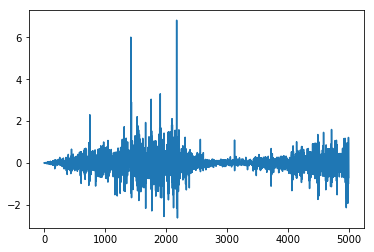

In [133]:
import matplotlib.pyplot as plt
plt.plot(x2)
sum(x2)

In [32]:
# takes current_weights (n,1), previous_prices(n,t), next_price_pred(n,1) outputs updated_weighted (n,1)
def rebalance(current_weights, previous_prices, next_price_prediction, transaction_cost=0.0005):
    expected_return = np.log(next_price_prediction/previous_prices[:,-1])
    sharpe = expected_return/previous_prices.std(axis=1)
    w = sharpe/np.sum(sharpe)
    delta_w = (w - current_weights)/current_weights
    change = np.repeat(0,11)
    for i in range(len(current_weights)):
        if (delta_w[0,i-1]*(expected_return[0,i-1] - transaction_cost) > 0 ) :
            change[i-1] = w[0,i-1]
    total_change = (1 - np.sum(current_weights[change == 0]))
    upd_weights = change * total_change/np.sum(change[change!=0])
    upd_weights[upd_weights==0] = current_weights[upd_weights==0]
    return upd_weights

            
            
    
    
    

In [33]:
import pylab

import random

random.seed()
previous_prices = np.array([random.gauss(100, 1) for _ in range(11*100)])
previous_prices = np.reshape(previous_prices,(11,100))
#np.shape(previous_prices)
#np.shape(previous_prices[:,-1])
#len(current_weights)
current_weights = np.repeat(1/11,11)
#previous_prices = np.repeat(100,11)
next_price_prediction = np.array([[95,96,97,98,99,100,101,102,103,104,105]])


In [118]:
sum([-1.00835304e-08, -1.41057215e-08, -6.31430920e-10, -8.91386841e-09,
  1.68087230e-08, -1.39296899e-08,  3.94351517e-03, -6.27512976e-09,
 -1.40332767e-08, -1.42251363e-08])

0.003943449780939109

In [120]:
sum([ 2.46827783e-09, -3.38387466e-09,  1.14274261e-09, -2.27042248e-09,
  1.99860033e+00, -2.84756164e-09,  1.42514222e-07, -1.91787958e-09,
 -3.07848920e-09, -3.21495098e-09])

1.9986004594120637

In [36]:
rebalance(current_weights, previous_prices, next_price_prediction, transaction_cost=0.0005)

array([-2.72727273, -0.90909091, -1.36363636, -0.45454545,  0.09090909,
        0.45454545,  0.90909091,  0.45454545,  0.90909091,  1.81818182,
        1.81818182])

In [14]:
def backtest(prices, predictions, initial_weights, length_past):
    


SyntaxError: unexpected EOF while parsing (<ipython-input-14-13c3a2a4ffff>, line 2)

NameError: name 'product' is not defined

In [15]:
def plot_result(stock_name, normalized_value_p, normalized_value_y_test):
    newp = denormalize(stock_name, normalized_value_p,predict=True)
    newy_test = denormalize(stock_name, normalized_value_y_test,predict=False)
    plt2.plot(newp, color='red', label='Prediction')
    plt2.plot(newy_test,color='blue', label='Actual')
    plt2.legend(loc='best')
    plt2.title('The test result for {}'.format(stock_name))
    plt2.xlabel('5 Min ahead Forecast')
    plt2.ylabel('Price')
    plt2.show()

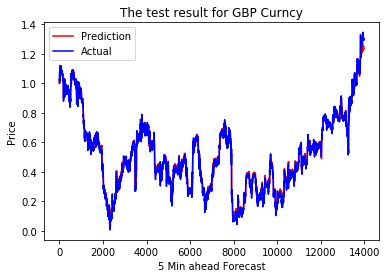

In [68]:
plot_result("GBP Curncy", p, y_test)

In [85]:
s=denormalize("GBP Curncy", y_test)

# WORKSPACE

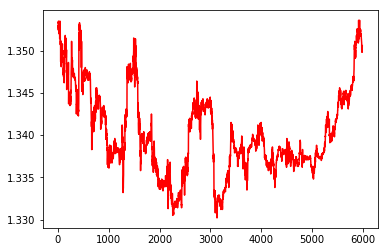

In [96]:
plt2.plot(s, color='red', label='Prediction')

In [ ]:
    stock=df_GBP
    split=0.7
    amount_of_features = len(stock.columns)
    print ("Amount of features = {}".format(amount_of_features))
    data = stock.as_matrix()
    sequence_length = seq_len + 1 
    result = []

    for index in range(len(data) - sequence_length): 
        result.append(data[index: index + sequence_length]) 

    result = np.array(result)
    row = round(split * result.shape[0]) 
    print ("Amount of training data = {}".format(split * result.shape[0]))
    print ("Amount of testing data = {}".format((1-split) * result.shape[0]))

    train = result[:int(row), :] 
    X_train = train[:, :-1] # all data until day m
    y_train = train[:, -1][:,-1] # day m + 1 adjusted close price

    X_test = result[int(row):, :-1]
    y_test = result[int(row):, -1][:,-1]

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], amount_of_features))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], amount_of_features))

In [99]:
    stock=df_GBP
    split=0.7
    amount_of_features = len(stock.columns)
    print ("Amount of features = {}".format(amount_of_features))
    data = stock.as_matrix()
    sequence_length = seq_len + 1 
    result = []

Amount of features = 9


In [100]:
    for index in range(len(data) - sequence_length): 
        result.append(data[index: index + sequence_length]) 

    result = np.array(result)
    row = round(split * result.shape[0]) 
    print ("Amount of training data = {}".format(split * result.shape[0]))
    print ("Amount of testing data = {}".format((1-split) * result.shape[0]))



Amount of training data = 13981.8
Amount of testing data = 5992.200000000001


In [101]:
    train = result[:int(row), :] 
    X_train = train[:, :-1] # all data until day m
    y_train = train[:, -1][:,-1] # day m + 1 adjusted close price



In [106]:
X_train[1]

array([[0.78544061, 0.79961089, 0.78998073, 0.18487646, 0.73263144,
        0.80178064, 0.85258554, 0.87962225, 0.79885057],
       [0.79885057, 0.79766537, 0.77842004, 0.20749075, 0.6302588 ,
        0.79992581, 0.85168128, 0.8792669 , 0.77777778],
       [0.77777778, 0.78210117, 0.77842004, 0.26946511, 0.69849806,
        0.79815341, 0.85088217, 0.87889001, 0.77969349],
       [0.77969349, 0.79182879, 0.78034682, 0.19646395, 0.72694989,
        0.79691686, 0.85020924, 0.87857774, 0.79118774],
       [0.79118774, 0.78793774, 0.79190751, 0.14544163, 0.68143137,
        0.79568031, 0.84941013, 0.87825469, 0.78735632],
       [0.78735632, 0.79182879, 0.76300578, 0.23328225, 0.61885336,
        0.79419645, 0.84833764, 0.87782396, 0.76245211],
       [0.76245211, 0.75680934, 0.74566474, 0.26950249, 0.63586454,
        0.79250649, 0.84694972, 0.87728555, 0.74329502],
       [0.74329502, 0.75291829, 0.74759152, 0.17295257, 0.73269675,
        0.7911875 , 0.84564591, 0.87682252, 0.75670498],


In [107]:
y_train

array([0.74329502, 0.74329502, 0.74329502, ..., 0.96934866, 0.96743295,
       0.95785441])

In [109]:
 X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], amount_of_features))

In [111]:
X_train[0]

array([[0.79501916, 0.79377432, 0.7822736 , 0.16065488, 0.66437187,
        0.80309962, 0.85321641, 0.87984838, 0.78544061],
       [0.78544061, 0.79961089, 0.78998073, 0.18487646, 0.73263144,
        0.80178064, 0.85258554, 0.87962225, 0.79885057],
       [0.79885057, 0.79766537, 0.77842004, 0.20749075, 0.6302588 ,
        0.79992581, 0.85168128, 0.8792669 , 0.77777778],
       [0.77777778, 0.78210117, 0.77842004, 0.26946511, 0.69849806,
        0.79815341, 0.85088217, 0.87889001, 0.77969349],
       [0.77969349, 0.79182879, 0.78034682, 0.19646395, 0.72694989,
        0.79691686, 0.85020924, 0.87857774, 0.79118774],
       [0.79118774, 0.78793774, 0.79190751, 0.14544163, 0.68143137,
        0.79568031, 0.84941013, 0.87825469, 0.78735632],
       [0.78735632, 0.79182879, 0.76300578, 0.23328225, 0.61885336,
        0.79419645, 0.84833764, 0.87782396, 0.76245211],
       [0.76245211, 0.75680934, 0.74566474, 0.26950249, 0.63586454,
        0.79250649, 0.84694972, 0.87728555, 0.74329502],


In [112]:
y_test

array([0.95402299, 0.95785441, 0.95785441, ..., 0.91187739, 0.90996169,
       0.91762452])

In [114]:
p = model.predict(X_test)

In [115]:
p

array([[0.95628846],
       [0.9523339 ],
       [0.94992006],
       ...,
       [0.9034717 ],
       [0.904866  ],
       [0.90557444]], dtype=float32)

In [116]:
len(p)

5992

In [117]:
min_max_scaler = preprocessing.MinMaxScaler()

new = min_max_scaler.inverse_transform(p)
      

NotFittedError: This MinMaxScaler instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

In [21]:
xl.sheet_names

['Sheet1',
 'GBP Curncy',
 'JPY Curncy',
 'USD Curncy',
 'EUR Curncy',
 'CAD Curncy',
 'NZD Curncy',
 'SEK Curncy',
 'AUD Curncy',
 'CHF Curncy',
 'NOK Curncy',
 'ZAR Curncy']

In [82]:

# Load spreadsheet
close = pd.ExcelFile('close.xlsx')

In [83]:
close

In [85]:
close = pd.ExcelFile('close.xlsx')
dq=np.array(close.parse(0))

In [86]:
dq

array([[  1.3462, 111.72  ,   1.1847, ...,   0.7935,   0.9669,   7.8175],
       [  1.3465, 111.72  ,   1.1849, ...,   0.7937,   0.967 ,   7.8172],
       [  1.3466, 111.72  ,   1.1848, ...,   0.7937,   0.9669,   7.8169],
       ...,
       [  1.3522, 112.63  ,   1.1993, ...,   0.7811,   0.9746,   8.1754],
       [  1.3525, 112.62  ,   1.1993, ...,   0.7812,   0.9745,   8.1774],
       [  1.3522, 112.61  ,   1.1996, ...,   0.7811,   0.9743,   8.1868]])

In [122]:
from   mosek.fusion import *

In [127]:
n      = 3;
w      = 0.06740718306100879;   
mu     = [0.1073,0.0737,0.0627]
x0     = [0.0,0.0,0.0]
gammas = [0.035,0.040,0.050,0.060,0.070,0.080,0.090]
GT     = [
        [ 0.1566673333200005, 0.0232190712557243 ,  0.0012599496030238 ],
        [ 0.0              , 0.102863378954911  , -0.00222873156550421],
        [ 0.0              , 0.0                ,  0.0338148677744977 ]]
f = n*[0.01]
g = n*[0.001]
MarkowitzWithTransactionsCost(n,mu,GT,x0,w,gammas[0],f,g)

(0.006153636871897642, array([0.05734983, 0.        , 0.        ]))